# Keras implementation of CLIP Model - Lorenzo Manoni & Gabriele Pagano

## Installations and imports

In [1]:
# Install required packages
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.3 MB/s eta 0:00:00


In [2]:
# Import required libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
import random
from transformers import TFBertModel, BertTokenizer, TFAutoModel
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tqdm import tqdm
from PIL import Image

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
# Mount on Google Drive
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [4]:
# Paths of the data
master_path = os.path.join("../gdrive/MyDrive/Transformers/")
git_path = os.path.join(master_path, "GP-dataset/")
data_path = os.path.join(git_path, "data/")
extraction_path = os.path.join("content/")
images_path = os.path.join(extraction_path, "resized_train/")
text_path = os.path.join(data_path, "text/")
caption_path = os.path.join(text_path, "caption_prediction_train.csv")
zip_file_path = os.path.join(data_path, "images/resized_train.zip")
concepts_path = os.path.join(text_path, "concept_detection_train.csv")
concepts_name_path = os.path.join(text_path, "concepts.csv")
roco_path = os.path.join(extraction_path ,"roco-dataset-master/")
roco_data_path = os.path.join(roco_path, "data/")
scripts_path = os.path.join(roco_path, "scripts/")
tfrecords_dir = os.path.join(master_path, "GP-tfrecords/")
tfrecords_dir_train = os.path.join(tfrecords_dir, "train/")
tfrecords_dir_valid = os.path.join(tfrecords_dir, "valid/")


# Paths of the generated model
model_path = os.path.join(master_path, "GP-model/")
last_epoch_path = os.path.join(model_path, "last_epoch.txt")
checkpoint_path = os.path.join(model_path, "model_checkpoint.h5")

## Data pre-processing - resized version

In [5]:
# Unzip the folder containing the data
if True:
    !unzip {zip_file_path} -d {extraction_path}

Output streaming troncato alle ultime 5000 righe.
  inflating: content/resized_train/ImageCLEFmedCaption_2022_train_078714.jpg  
  inflating: content/resized_train/ImageCLEFmedCaption_2022_train_078715.jpg  
  inflating: content/resized_train/ImageCLEFmedCaption_2022_train_078716.jpg  
  inflating: content/resized_train/ImageCLEFmedCaption_2022_train_078717.jpg  
  inflating: content/resized_train/ImageCLEFmedCaption_2022_train_078718.jpg  
 extracting: content/resized_train/ImageCLEFmedCaption_2022_train_078719.jpg  
  inflating: content/resized_train/ImageCLEFmedCaption_2022_train_078720.jpg  
  inflating: content/resized_train/ImageCLEFmedCaption_2022_train_078721.jpg  
  inflating: content/resized_train/ImageCLEFmedCaption_2022_train_078722.jpg  
  inflating: content/resized_train/ImageCLEFmedCaption_2022_train_078723.jpg  
  inflating: content/resized_train/ImageCLEFmedCaption_2022_train_078724.jpg  
  inflating: content/resized_train/ImageCLEFmedCaption_2022_train_078725.jpg  
  

In [6]:
# Import captions dataframe and inspect it
captions = pd.read_csv(caption_path, delimiter='\t')
print(captions.describe)

<bound method NDFrame.describe of                                           ID  \
0      ImageCLEFmedCaption_2022_train_000001   
1      ImageCLEFmedCaption_2022_train_000002   
2      ImageCLEFmedCaption_2022_train_000003   
3      ImageCLEFmedCaption_2022_train_000004   
4      ImageCLEFmedCaption_2022_train_000005   
...                                      ...   
83270  ImageCLEFmedCaption_2022_train_084253   
83271  ImageCLEFmedCaption_2022_train_084254   
83272  ImageCLEFmedCaption_2022_train_084255   
83273  ImageCLEFmedCaption_2022_train_084256   
83274  ImageCLEFmedCaption_2022_train_084257   

                                                 caption  
0      pericardial tamponade with clear distinction o...  
1      angiography of the aortic arch show delay visu...  
2      balloonocclude retrograde transvenous oblitera...  
3      film after glue embolization show no filling i...  
4      peripheral in posteroanterior projection angio...  
...                                

In [7]:
# Creation of a dictionary that maps, for each image path, the related
# caption

data_path_to_caption = collections.defaultdict(list)
for index in captions.index.values:
  image_path = os.path.join(images_path, captions.iloc[index]['ID'] + ".jpg")
  if os.path.isfile(image_path):
    data_path_to_caption[image_path].append(captions.iloc[index]['caption'])

In [8]:
# Print how many items (images and captions) we have in the dataset
data_image_paths = list(data_path_to_caption.keys())
print(f"Number of total images: {len(data_image_paths)}")

Number of total images: 83275


In [9]:
data_captions = list(data_path_to_caption.values())
print(len(data_captions))

83275


In [10]:
# Each caption now is a list of one single element. This snippet of code takes
# the element (i.e., the caption string) from each list and remove its leading
# whitespaces

for path in data_image_paths:
  data_path_to_caption[path] = data_path_to_caption[path][0].lstrip()

In [11]:
# Creation of a new dataframe with the new renamed images paths
data_tuples = [(key, value) for key, value in data_path_to_caption.items()]
dataframe = pd.DataFrame(data_tuples, columns=['image', 'caption'])
print(dataframe.describe)

<bound method NDFrame.describe of                                                    image  \
0      content/resized_train/ImageCLEFmedCaption_2022...   
1      content/resized_train/ImageCLEFmedCaption_2022...   
2      content/resized_train/ImageCLEFmedCaption_2022...   
3      content/resized_train/ImageCLEFmedCaption_2022...   
4      content/resized_train/ImageCLEFmedCaption_2022...   
...                                                  ...   
83270  content/resized_train/ImageCLEFmedCaption_2022...   
83271  content/resized_train/ImageCLEFmedCaption_2022...   
83272  content/resized_train/ImageCLEFmedCaption_2022...   
83273  content/resized_train/ImageCLEFmedCaption_2022...   
83274  content/resized_train/ImageCLEFmedCaption_2022...   

                                                 caption  
0      pericardial tamponade with clear distinction o...  
1      angiography of the aortic arch show delay visu...  
2      balloonocclude retrograde transvenous oblitera...  
3      fi

In [12]:
# add an index column to the data frame
dataframe['id'] = dataframe.index.values
print(dataframe.describe)

<bound method NDFrame.describe of                                                    image  \
0      content/resized_train/ImageCLEFmedCaption_2022...   
1      content/resized_train/ImageCLEFmedCaption_2022...   
2      content/resized_train/ImageCLEFmedCaption_2022...   
3      content/resized_train/ImageCLEFmedCaption_2022...   
4      content/resized_train/ImageCLEFmedCaption_2022...   
...                                                  ...   
83270  content/resized_train/ImageCLEFmedCaption_2022...   
83271  content/resized_train/ImageCLEFmedCaption_2022...   
83272  content/resized_train/ImageCLEFmedCaption_2022...   
83273  content/resized_train/ImageCLEFmedCaption_2022...   
83274  content/resized_train/ImageCLEFmedCaption_2022...   

                                                 caption     id  
0      pericardial tamponade with clear distinction o...      0  
1      angiography of the aortic arch show delay visu...      1  
2      balloonocclude retrograde transvenous ob

In [13]:
# Parameters configuration class
class CFG:
    debug = False
    image_path = images_path
    captions_path = caption_path
    batch_size = 64
    buffer_size = 5000
    head_lr = 1e-4
    encoders_lr = 1e-5
    weight_decay = 0.2
    patience_stop = 12
    factor = 0.2
    epochs = 25
    initial_epochs = 8
    text_url = "google/bert_uncased_L-4_H-512_A-8"
    max_length = 200
    adam_epsilon = 1e-08
    alpha = 1e-6
    warmup_target = 5e-4
    warmup_steps = 200
    decay_steps = epochs * 1041 # (because given our resized dataset we have
                                # 1041 steps per epoch)
    exp_decay_steps = (epochs - initial_epochs) * 1041
    exp_decay_rate = 0.9


    pretrained = True # for both image encoder and text encoder
    trainable = False # for both image encoder and text encoder
    temperature = 0.0

    # image size
    size = 224

    # for projection head, used for both image and text encoders
    num_projection_layers = 2

    projection_dim = 512
    dropout = 0.1

In [ ]:
# Function to random split the original dataframe into a train and a validation
# ones

def make_train_valid_dfs():
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 300
    image_ids = np.arange(0, max_id)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[
        dataframe["id"].isin(train_ids)].reset_index(
            drop=True
            )
    valid_dataframe = dataframe[
        dataframe["id"].isin(valid_ids)].reset_index(
            drop=True
            )
    return train_dataframe, valid_dataframe

In [ ]:
train_dataframe, valid_dataframe = make_train_valid_dfs()

In [ ]:
print(train_dataframe.describe)

<bound method NDFrame.describe of                                                    image  \
0      content/resized_train/ImageCLEFmedCaption_2022...   
1      content/resized_train/ImageCLEFmedCaption_2022...   
2      content/resized_train/ImageCLEFmedCaption_2022...   
3      content/resized_train/ImageCLEFmedCaption_2022...   
4      content/resized_train/ImageCLEFmedCaption_2022...   
...                                                  ...   
66615  content/resized_train/ImageCLEFmedCaption_2022...   
66616  content/resized_train/ImageCLEFmedCaption_2022...   
66617  content/resized_train/ImageCLEFmedCaption_2022...   
66618  content/resized_train/ImageCLEFmedCaption_2022...   
66619  content/resized_train/ImageCLEFmedCaption_2022...   

                                                 caption     id  
0      angiography of the aortic arch show delay visu...      1  
1      balloonocclude retrograde transvenous oblitera...      2  
2      film after glue embolization show no fil

In [ ]:
# Now, let's create a dictionary that maps, for each image path, the related
# caption
train_path_to_caption = collections.defaultdict(list)
for index in train_dataframe.index.values:
  image_path = train_dataframe.iloc[index]['image']
  if os.path.isfile(image_path):
    train_path_to_caption[image_path].append(
        train_dataframe.iloc[index]['caption']
        )

In [ ]:
train_image_paths = list(train_path_to_caption.keys())
print(len(train_image_paths))

66620


In [ ]:
train_captions = list(train_path_to_caption.values())
print(len(train_captions))

66620


In [ ]:
print(valid_dataframe.describe)

<bound method NDFrame.describe of                                                    image  \
0      content/resized_train/ImageCLEFmedCaption_2022...   
1      content/resized_train/ImageCLEFmedCaption_2022...   
2      content/resized_train/ImageCLEFmedCaption_2022...   
3      content/resized_train/ImageCLEFmedCaption_2022...   
4      content/resized_train/ImageCLEFmedCaption_2022...   
...                                                  ...   
16650  content/resized_train/ImageCLEFmedCaption_2022...   
16651  content/resized_train/ImageCLEFmedCaption_2022...   
16652  content/resized_train/ImageCLEFmedCaption_2022...   
16653  content/resized_train/ImageCLEFmedCaption_2022...   
16654  content/resized_train/ImageCLEFmedCaption_2022...   

                                                 caption     id  
0      pericardial tamponade with clear distinction o...      0  
1      peripheral in posteroanterior projection angio...      4  
2      the right judkins catheter be gently pul

In [ ]:
# Let's do the same with the validation dataframe
valid_path_to_caption = collections.defaultdict(list)
for index in valid_dataframe.index.values:
  image_path = valid_dataframe.iloc[index]['image']
  if os.path.isfile(image_path):
    valid_path_to_caption[image_path].append(
        valid_dataframe.iloc[index]['caption']
        )

In [ ]:
valid_image_paths = list(valid_path_to_caption.keys())
print(len(valid_image_paths))

16655


In [ ]:
valid_captions = list(valid_path_to_caption.values())
print(len(valid_captions))

16655


In [ ]:
# Extract actual captions from the sets of captions (before this statement they
# were lists of lists)

train_captions = [
    item.strip('\'"') for sublist in train_captions for item in sublist
    ]
valid_captions = [
    item.strip('\'"') for sublist in valid_captions for item in sublist
    ]

In [ ]:
for key, new_caption in zip(train_path_to_caption.keys(), train_captions):
        train_path_to_caption[key] = new_caption


for key, new_caption in zip(valid_path_to_caption.keys(), valid_captions):
        valid_path_to_caption[key] = new_caption

In [14]:
# Import text tokenizer
tokenizer = BertTokenizer.from_pretrained(CFG.text_url)

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

## Data pre-processing - non resized version

In [ ]:
# Retrieve the dataset
if(not os.path.isdir(roco_path)):
  !wget https://github.com/razorx89/roco-dataset/archive/refs/heads/master.zip
  !unzip /content/master.zip -d {extraction_path}

--2023-12-20 19:28:26--  https://github.com/razorx89/roco-dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/razorx89/roco-dataset/zip/refs/heads/master [following]
--2023-12-20 19:28:26--  https://codeload.github.com/razorx89/roco-dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.10
Connecting to codeload.github.com (codeload.github.com)|140.82.121.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [        <=>         ]  12.98M  6.13MB/s    in 2.1s    

2023-12-20 19:28:28 (6.13 MB/s) - ‘master.zip’ saved [13613348]

Archive:  /content/master.zip
a1f0ad6c578ca8801e5a6eccc90af051aee1c326
   creating: content/roco-dataset-master/
  inflating: con

Fetching parameters:

* `-c` print configuration and exit
* `-s` name of image subdirectory, relative to dlinks.txt location
* `-e` path to the directory where downloaded archives and images are extracted before being moved to the data subdirectory
* `-d` to avoid loss of data, this must be passed to confirm that all data in the extraction directory will be deleted
* `-k` keep downloaded archives after extraction. Ensure sufficient available disk space at the extraction directory location
* `-n` number of parallel processes, reduce this if you are being locked out of the PMC FTP service
* `-r` number of retries for failed downloads before giving up

In [ ]:
# script we used to fetch the images
!cd ../content/roco-dataset-master/scripts/
!python {os.path.join(scripts_path, "fetch.py")} -d -n 50

Output streaming troncato alle ultime 5000 righe.
91.418% | 42599/46598 | PMC4351448
91.420% | 42600/46598 | PMC2971489
91.422% | 42601/46598 | PMC3084338
91.425% | 42602/46598 | PMC5469240
Error: download failed, retrying
Trying to get new archive URL: https://www.ncbi.nlm.nih.gov/pmc/utils/oa/oa.fcgi?tool=roco-fetch&email=johannes.rueckert@fh-dortmund.de&id=PMC4790144
91.427% | 42603/46598 | PMC4561672
91.429% | 42604/46598 | PMC3852286
91.431% | 42605/46598 | PMC2881520
91.433% | 42606/46598 | PMC4589341
91.435% | 42607/46598 | PMC4349483
91.437% | 42608/46598 | PMC2797769
91.440% | 42609/46598 | PMC4195934
91.442% | 42610/46598 | PMC3621155
91.444% | 42611/46598 | PMC4782466
91.446% | 42612/46598 | PMC5021277
91.448% | 42613/46598 | PMC2831984
91.450% | 42614/46598 | PMC4247469
91.452% | 42615/46598 | PMC4541788
91.455% | 42616/46598 | PMC3678807
91.457% | 42617/46598 | PMC4146217
91.459% | 42618/46598 | PMC239963
91.461% | 42619/46598 | PMC2737150
91.463% | 42620/46598 | PMC415725

In [ ]:
# Function that, given a list of paths, returns a dictionary that stores the
# caption associated with each image. For each value of the dictionary, the
# corresponding key is the path of the image associated with that specific
# caption

def PathToCaption(paths):
  collectionList = collections.defaultdict(list)
  for caption_path in paths:
    print("Reading from: " + caption_path)
    caption_file = os.path.join(caption_path, "captions.txt")
    captions = pd.read_csv(caption_file, delimiter='\t',
                           names=['Image', 'Caption'])
    images_path = os.path.join(caption_path, "images/")
    for index in captions.index.values:
      image_path = os.path.join(images_path,
                                captions.iloc[index]['Image'] + ".jpg")
      if os.path.isfile(image_path):
        collectionList[image_path].append(captions.iloc[index]['Caption'])
  return collectionList

In [ ]:
# Creation of the above defined dictionary

data_paths = [os.path.join(roco_data_path, "train/radiology/"),
              os.path.join(roco_data_path, "test/radiology/"),
              os.path.join(roco_data_path, "validation/radiology/")]
data_path_to_caption = PathToCaption(data_paths)
data_image_paths = list(data_path_to_caption.keys())
print(f"Number of total images: {len(data_image_paths)}")

Reading from: content/roco-dataset-master/data/train/radiology/
Reading from: content/roco-dataset-master/data/test/radiology/
Reading from: content/roco-dataset-master/data/validation/radiology/
Number of total images: 81771


In [ ]:
# Each caption now is a list of one single element. This snippet of code takes
# the element (i.e., the caption string) from each list and remove its leading
# whitespaces

for path in data_image_paths:
  data_path_to_caption[path] = data_path_to_caption[path][0].lstrip()

In [ ]:
data_captions = list(data_path_to_caption.values())

In [ ]:
data_captions = [
    item.strip('\'"') for sublist in data_captions for item in sublist
    ]

- Preoperative CT imaging of case 2
- RICA injection in lateral projection post successful CAS with minimal residual stenosis and good TICI III flow without EPD-induced spasm or dissection
- CT abdomen (Transverse section) showing a large caudate lobe liver mass involving the gall bladder and common bile duct at porta with IHBR dilatation
- Joint between sixth and seventh cervicals vertebrae of Sauroposeidon.X-ray scout image of the C6/C7 intervertebral joint in Sauroposeidon OMNH 53062, in right lateral view. The silhouette of the condyle is traced in blue and the cotyle in red. The scale on the right is marked off in centimeters, although the numbers next to each mark are in millimeters.
- Magnetic resonance imaging scan image showing an ill-defined lesion in the left half of anterior portion of tongue
- Chest X-ray of an ARDS victim that suffered a grade 4 SAH.
- Image échographique montrant l'aorte (AO) et l'artère pulmonaire (AP)
- Multicystic dysplastic right kidney in the fetus 

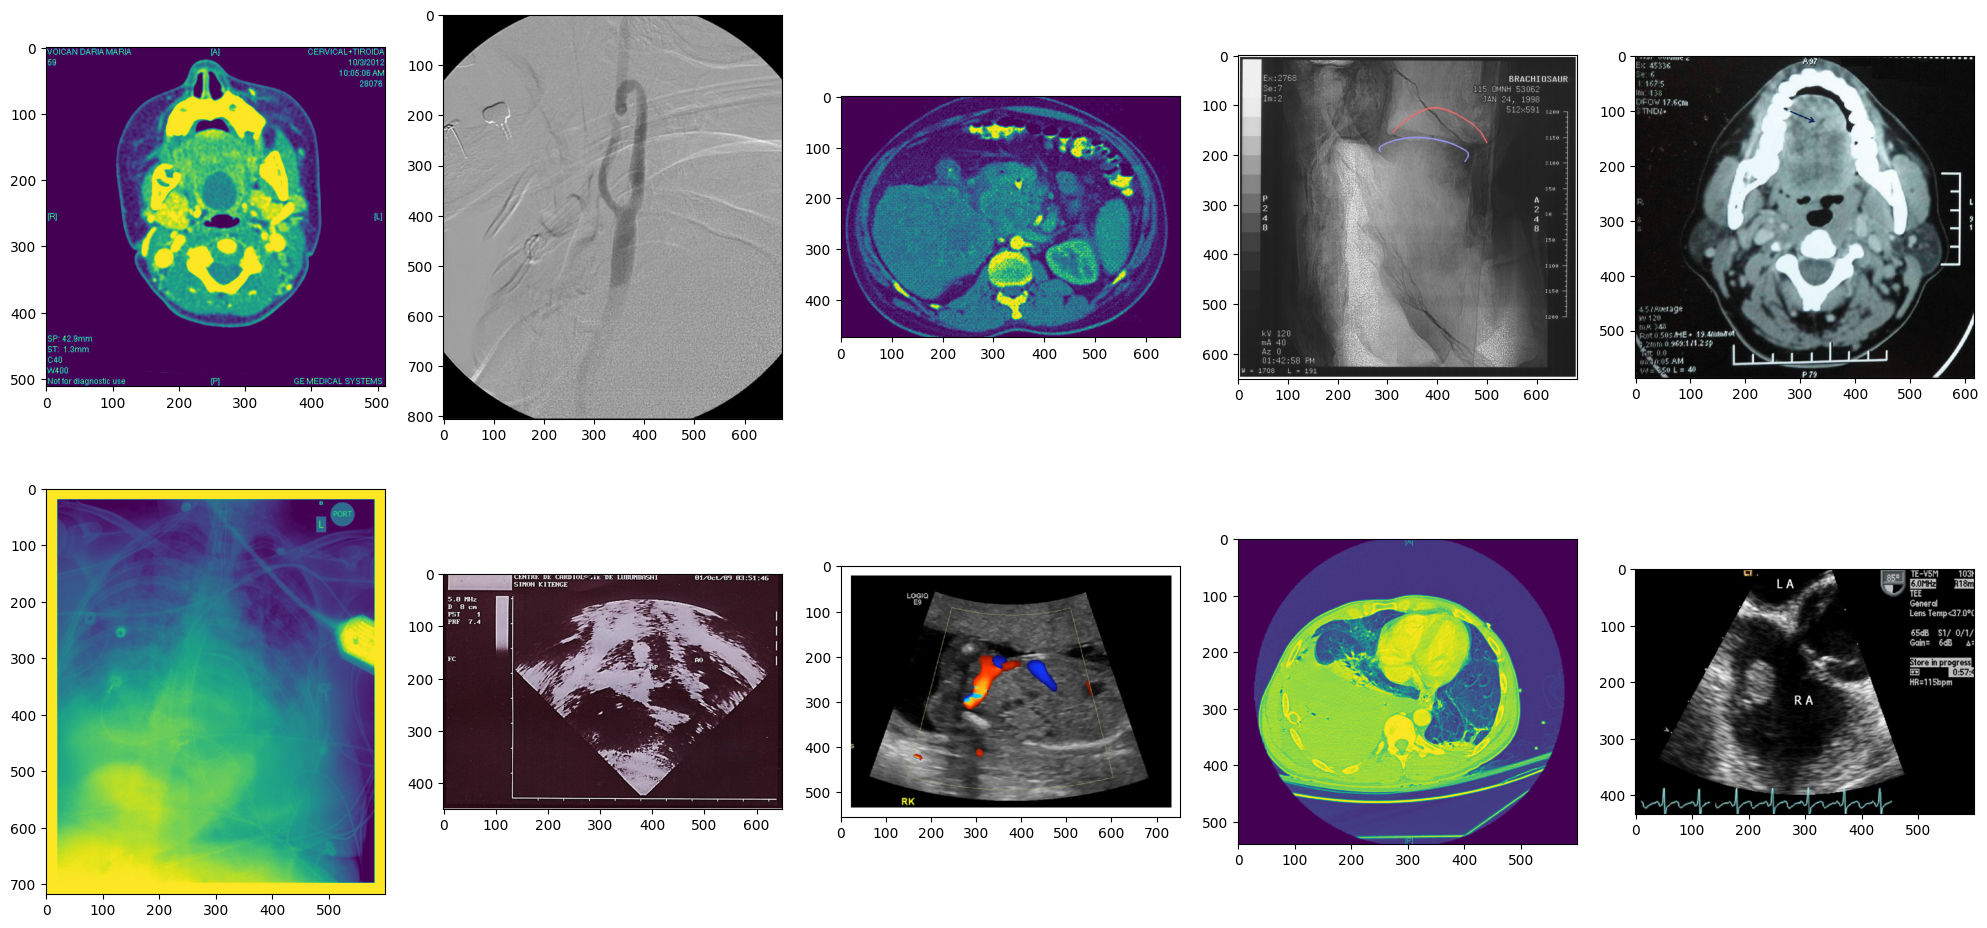

In [ ]:
# Random inspection of some captions and the related images

full_dataset_size = len(data_image_paths)
n_samples = 10
num_row = 2
num_col = 5
rands = []
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))

for i in range(n_samples):
  rands.append(np.random.choice(range(full_dataset_size)))
  print("- " + str(data_path_to_caption[data_image_paths[rands[i]]]))
  image = Image.open(data_image_paths[rands[i]])
  ax = axes[i//num_col, i%num_col]
  ax.imshow(image)

plt.tight_layout()
plt.show()

In [ ]:
# Creation of a new dataframe with the new renamed images paths
data_tuples = [(key, value) for key, value in data_path_to_caption.items()]
dataframe = pd.DataFrame(data_tuples, columns=['image', 'caption'])
print(dataframe.describe)

<bound method NDFrame.describe of                                                    image  \
0      content/roco-dataset-master/data/train/radiolo...   
1      content/roco-dataset-master/data/train/radiolo...   
2      content/roco-dataset-master/data/train/radiolo...   
3      content/roco-dataset-master/data/train/radiolo...   
4      content/roco-dataset-master/data/train/radiolo...   
...                                                  ...   
81766  content/roco-dataset-master/data/validation/ra...   
81767  content/roco-dataset-master/data/validation/ra...   
81768  content/roco-dataset-master/data/validation/ra...   
81769  content/roco-dataset-master/data/validation/ra...   
81770  content/roco-dataset-master/data/validation/ra...   

                                                 caption  
0      Computed tomography scan in axial view showing...  
1      Bacterial contamination occurred after complet...  
2      The patient had residual paralysis of the hand...  
3        

In [ ]:
# add an index column to the data frame
dataframe['id'] = dataframe.index.values
print(dataframe.describe)

<bound method NDFrame.describe of                                                    image  \
0      content/roco-dataset-master/data/train/radiolo...   
1      content/roco-dataset-master/data/train/radiolo...   
2      content/roco-dataset-master/data/train/radiolo...   
3      content/roco-dataset-master/data/train/radiolo...   
4      content/roco-dataset-master/data/train/radiolo...   
...                                                  ...   
81766  content/roco-dataset-master/data/validation/ra...   
81767  content/roco-dataset-master/data/validation/ra...   
81768  content/roco-dataset-master/data/validation/ra...   
81769  content/roco-dataset-master/data/validation/ra...   
81770  content/roco-dataset-master/data/validation/ra...   

                                                 caption     id  
0      Computed tomography scan in axial view showing...      0  
1      Bacterial contamination occurred after complet...      1  
2      The patient had residual paralysis of th

In [5]:
# Parameters configuration class
class CFG:
    debug = False
    image_path = images_path
    captions_path = caption_path
    batch_size = 64
    buffer_size = 5000
    head_lr = 1e-4
    encoders_lr = 1e-5
    weight_decay = 0.2
    patience_stop = 5
    factor = 0.2
    epochs = 25
    initial_epochs = 8
    text_url = "google/bert_uncased_L-4_H-512_A-8"
    max_length = 200
    adam_epsilon = 1e-08
    alpha = 1e-6
    warmup_target = 5e-4
    warmup_steps = 200
    decay_steps = epochs * 1041 # (because given our resized dataset we have
                                # 1041 steps per epoch)
    exp_decay_steps = (epochs - initial_epochs) * 1041
    exp_decay_rate = 0.9


    pretrained = True # for both image encoder and text encoder
    trainable = False # for both image encoder and text encoder
    temperature = 0.0

    # image size
    size = 224 #128 (for resized images)

    # for projection head, used for both image and text encoders
    num_projection_layers = 2

    projection_dim = 512
    dropout = 0.1

In [ ]:
# Function to random split the original dataframe into a train and a validation
# ones

def make_train_valid_dfs():
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 300
    image_ids = np.arange(0, max_id)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[
        dataframe["id"].isin(train_ids)].reset_index(
            drop=True
            )
    valid_dataframe = dataframe[
        dataframe["id"].isin(valid_ids)].reset_index(
            drop=True
            )
    return train_dataframe, valid_dataframe

In [ ]:
train_dataframe, valid_dataframe = make_train_valid_dfs()

In [ ]:
print(train_dataframe.describe)

In [ ]:
# Now, let's create a dictionary that maps, for each image path, the related
# caption
train_path_to_caption = collections.defaultdict(list)
for index in train_dataframe.index.values:
  image_path = train_dataframe.iloc[index]['image']
  if os.path.isfile(image_path):
    train_path_to_caption[image_path].append(
        train_dataframe.iloc[index]['caption']
        )

In [ ]:
train_image_paths = list(train_path_to_caption.keys())
print(len(train_image_paths))

In [ ]:
train_captions = list(train_path_to_caption.values())
print(len(train_captions))

In [ ]:
print(valid_dataframe.describe)

In [ ]:
# Let's do the same with the validation dataframe
valid_path_to_caption = collections.defaultdict(list)
for index in valid_dataframe.index.values:
  image_path = valid_dataframe.iloc[index]['image']
  if os.path.isfile(image_path):
    valid_path_to_caption[image_path].append(
        valid_dataframe.iloc[index]['caption']
        )

In [ ]:
valid_image_paths = list(valid_path_to_caption.keys())
print(len(valid_image_paths))

In [ ]:
valid_captions = list(valid_path_to_caption.values())
print(len(valid_captions))

In [ ]:
# Extract actual captions from the sets of captions (before this statement they
# were lists of lists)

train_captions = [
    item.strip('\'"') for sublist in train_captions for item in sublist
    ]
valid_captions = [
    item.strip('\'"') for sublist in valid_captions for item in sublist
    ]

In [6]:
# Import text tokenizer
tokenizer = BertTokenizer.from_pretrained(CFG.text_url)

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

In [ ]:
for key, new_caption in zip(train_path_to_caption.keys(), train_captions):
        train_path_to_caption[key] = new_caption


for key, new_caption in zip(valid_path_to_caption.keys(), valid_captions):
        valid_path_to_caption[key] = new_caption

### Save data as TFRecords

In [ ]:
# Parameters definitions
num_samples = 4096
train_size = len(train_image_paths)
valid_size = len(valid_image_paths)


num_tfrecords_train = int(np.ceil(train_size / num_samples))
num_tfrecords_valid = int(np.ceil(valid_size / num_samples))


train_files_prefix = os.path.join(tfrecords_dir_train, "train")
valid_files_prefix = os.path.join(tfrecords_dir_valid, "val")


tf.io.gfile.makedirs(tfrecords_dir)
tf.io.gfile.makedirs(tfrecords_dir_train)
tf.io.gfile.makedirs(tfrecords_dir_valid)

In [ ]:
# Helper functions
def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList
                            (value=[value]))


def create_example(image_path, caption):
    feature = {
        "caption": bytes_feature(caption.encode()),
        "raw_image": bytes_feature(tf.io.read_file(image_path).numpy()),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def write_tfrecords(file_name, image_paths, image_captions_dict):
    caption_list = []
    for image_path in image_paths:
        caption_list.append(image_captions_dict[image_path])

    with tf.io.TFRecordWriter(file_name) as writer:
        for example_idx in range(len(image_paths)):
            example = create_example(
                image_paths[example_idx], caption_list[example_idx]
            )
            writer.write(example.SerializeToString())
    return example_idx + 1


def write_data(image_paths, num_files, files_prefix, image_path_to_caption):
    counter = 0
    with tqdm(total=num_files) as pbar:
        for file_idx in range(num_files):
          file_name = files_prefix + "-%02d.tfrecord" % (file_idx)
          start_idx = num_samples * file_idx
          end_idx = start_idx + num_samples
          counter += write_tfrecords(file_name, image_paths[start_idx:end_idx],
                                      image_path_to_caption)
          pbar.update(1)
    return counter



train_count = write_data(train_image_paths, num_tfrecords_train,
                         train_files_prefix, train_path_to_caption)
print(f"{train_count} training examples were written to tfrecord files.")


valid_count = write_data(valid_image_paths, num_tfrecords_valid,
                       valid_files_prefix, valid_path_to_caption)
print(f"{valid_count} evaluation examples were written to tfrecord files.")

### Parse data from TFRecords

In [ ]:
# Run this cell if you want to run model v3 (this contains
# the right pre-processing for ResNet-50), otherwise run
# the next cell




# Create a dictionary describing the features
feature_description = {
    "caption": tf.io.FixedLenFeature([], tf.string),
    "raw_image": tf.io.FixedLenFeature([], tf.string),
}


def tokenize_map_function(caption):
    encoded = tokenizer.encode_plus(
        caption.numpy().decode('utf-8'),
        add_special_tokens=True,
        max_length=CFG.max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True
    )
    return encoded['input_ids'], encoded['attention_mask']


def preprocess_function(example):
    # Captions pre-processing
    features = tf.io.parse_single_example(example, feature_description)
    caption = features.pop('caption')
    # Text tokenization
    input_ids, attention_mask = tf.py_function(
        tokenize_map_function,
        [caption],
        [tf.int32, tf.int32]
    )
    input_ids.set_shape([CFG.max_length])
    attention_mask.set_shape([CFG.max_length])


    # Images pre-processing
    image = features.pop('raw_image')
    image = tf.image.resize(
        tf.image.decode_jpeg(image, channels=3), size=(CFG.size, CFG.size)
    )
    image = tf.keras.applications.resnet.preprocess_input(image)

    return {'input_ids': input_ids, 'attention_mask': attention_mask,
            'image': image}



# Get the dataset from the TFRecords
def get_dataset(file_pattern):

    return (
        tf.data.TFRecordDataset(tf.data.Dataset.list_files(file_pattern))
        .map(
            preprocess_function,
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=False,
        )
        .shuffle(CFG.buffer_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

In [13]:
# Create a dictionary describing the features
feature_description = {
    "caption": tf.io.FixedLenFeature([], tf.string),
    "raw_image": tf.io.FixedLenFeature([], tf.string),
}


def tokenize_map_function(caption):
    encoded = tokenizer.encode_plus(
        caption.numpy().decode('utf-8'),
        add_special_tokens=True,
        max_length=CFG.max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True
    )
    return encoded['input_ids'], encoded['attention_mask']


def preprocess_train_function(example):
    # Captions pre-processing
    features = tf.io.parse_single_example(example, feature_description)
    caption = features.pop('caption')
    # Text tokenization
    input_ids, attention_mask = tf.py_function(
        tokenize_map_function,
        [caption],
        [tf.int32, tf.int32]
    )
    input_ids.set_shape([CFG.max_length])
    attention_mask.set_shape([CFG.max_length])


    # Images pre-processing (normalize images in the [-1,1] range)
    image = features.pop('raw_image')
    image = tf.image.resize(
        tf.image.decode_jpeg(image, channels=3), size=(CFG.size, CFG.size)
    )
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5

    # Lines of code that perform data augmentation on images. Comment them if
    # you don't want data augmentation to be performed


    # Random rotation
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0,
                                                    maxval=4, dtype=tf.int32))

    # Specular reflection
    image = tf.image.random_flip_left_right(image)

    # Random contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random Gaussian noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1,
                             dtype=tf.float32)
    image = tf.add(image, noise)
    image = tf.clip_by_value(image, 0.0, 1.0)

    return {'input_ids': input_ids, 'attention_mask': attention_mask,
            'image': image}



def preprocess_val_function(example):
    # Captions pre-processing
    features = tf.io.parse_single_example(example, feature_description)
    caption = features.pop('caption')
    # Text tokenization
    input_ids, attention_mask = tf.py_function(
        tokenize_map_function,
        [caption],
        [tf.int32, tf.int32]
    )
    input_ids.set_shape([CFG.max_length])
    attention_mask.set_shape([CFG.max_length])


    # Images pre-processing (normalize images in the [-1,1] range)
    image = features.pop('raw_image')
    image = tf.image.resize(
        tf.image.decode_jpeg(image, channels=3), size=(CFG.size, CFG.size)
    )
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5

    return {'input_ids': input_ids, 'attention_mask': attention_mask,
            'image': image}


# Get the training dataset from the TFRecords
def get_train_dataset(file_pattern):

    return (
        tf.data.TFRecordDataset(tf.data.Dataset.list_files(file_pattern))
        .map(
            preprocess_train_function,
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=False,
        )
        .shuffle(CFG.buffer_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )



# Get the validation dataset from the TFRecords
def get_val_dataset(file_pattern):

    return (
        tf.data.TFRecordDataset(tf.data.Dataset.list_files(file_pattern))
        .map(
            preprocess_val_function,
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=False,
        )
        .shuffle(CFG.buffer_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

In [14]:
# Create datasets
train_file_pattern = os.path.join(tfrecords_dir_train, '*')
train_dataset = get_train_dataset(train_file_pattern)


valid_file_pattern = os.path.join(tfrecords_dir_valid, '*')
valid_dataset = get_val_dataset(valid_file_pattern)


# Calculate the number of samples
train_samples = sum(1 for _ in train_dataset)
valid_samples = sum(1 for _ in valid_dataset)

In [15]:
print("Number of samples in the training set: {}".format(train_samples))
print("Number of samples in the validation set: {}".format(valid_samples))

Number of samples in the training set: 65415
Number of samples in the validation set: 16353


In [16]:
train_dataset = train_dataset.batch(CFG.batch_size)
valid_dataset = valid_dataset.batch(CFG.batch_size)

## Models v1 and v3

In [ ]:
# run this only if you want to train model v1

def tokenize_map_function(caption):
    encoded = tokenizer.encode_plus(
        caption.numpy().decode('utf-8'),
        add_special_tokens=True,
        max_length=CFG.max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True
    )
    return encoded['input_ids'], encoded['attention_mask']


def preprocess_function(image_path, caption):
    # Text tokenization
    input_ids, attention_mask = tf.py_function(
        tokenize_map_function,
        [caption],
        [tf.int32, tf.int32]
    )
    input_ids.set_shape([CFG.max_length])
    attention_mask.set_shape([CFG.max_length])


    # Images pre-processing
    image_file = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image_file, channels=3)
    image = tf.image.resize(image, [CFG.size, CFG.size])
    image = tf.keras.applications.resnet.preprocess_input(image)

    return {'input_ids': input_ids, 'attention_mask': attention_mask,
            'image': image}

In [ ]:
# Datasets creation (only for model v1)
train_dataset = tf.data.Dataset.from_tensor_slices((train_dataframe['image'],
                                                    train_dataframe['caption']))
train_dataset = train_dataset.map(preprocess_function).shuffle(
    CFG.buffer_size
    ).prefetch(
        buffer_size=tf.data.AUTOTUNE
        ).batch(
            CFG.batch_size
            )


valid_dataset = tf.data.Dataset.from_tensor_slices((valid_dataframe['image'],
                                                    valid_dataframe['caption']))
valid_dataset = valid_dataset.map(preprocess_function).shuffle(
    CFG.buffer_size
    ).prefetch(
        buffer_size=tf.data.AUTOTUNE
        ).batch(
            CFG.batch_size
            )

In [ ]:
# Our first version of the CLIP model includes the following image encoder:
# A ResNet50 Convolutional Neural Network from keras.applications
class ImageEncoder(tf.keras.Model):
    """
    Encode images to a fixed size vector
    """
    def __init__(self, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super(ImageEncoder, self).__init__()
        self.model = tf.keras.applications.ResNet50(include_top=False,
                                                    weights='imagenet' if pretrained else None,
                                                    pooling='avg')
        self.model.trainable = trainable

    def call(self, x):
        return self.model(x)

In [ ]:
image_encoder = ImageEncoder(trainable=True)
image_encoder.build(input_shape=(None, CFG.size, CFG.size, 3))

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
print(image_encoder.summary())

Model: "image_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 23534592 (89.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________
None


In [ ]:
# This is the text encoder architecture that we will use for all the versions
# of CLIP: a 4-layers BERT-small architecture from Hugging Face Transformers
# library

class TextEncoder(tf.keras.Model):
    """
    Encode text to a fixed size vector using Small BERT from Hugging Face Transformers
    """
    def __init__(self, model_name=CFG.text_url,
                 trainable=CFG.trainable):
        super(TextEncoder, self).__init__()
        self.bert_layer = TFBertModel.from_pretrained(model_name,
                                                      from_pt=True,
                                                      trainable=trainable)
        self.bert_layer.trainable = trainable


    def call(self, input_ids, attention_mask):
        token_type_ids = tf.zeros_like(input_ids)
        outputs = self.bert_layer(input_ids, attention_mask=attention_mask,
                                  token_type_ids=token_type_ids)
        return outputs.pooler_output

In [ ]:
text_encoder = TextEncoder(trainable=False)

pytorch_model.bin:   0%|          | 0.00/116M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [ ]:
# Pass a dummy input to the model to build it and be able to print the summary
example_input_ids = tf.random.uniform([1, 200], dtype=tf.int32, minval=0,
                                      maxval=100)
example_attention_mask = tf.random.uniform([1, 200], dtype=tf.int32, minval=0,
                                           maxval=1)

_ = text_encoder(example_input_ids, example_attention_mask)

In [ ]:
print(text_encoder.summary())

Model: "text_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model (TFBertModel  multiple                  28763648  
 )                                                               
                                                                 
Total params: 28763648 (109.72 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 28763648 (109.72 MB)
_________________________________________________________________
None


In [ ]:
# The projection head is used to transform the image and the text embeddings
#to the same embedding space with the same dimensionality

class ProjectionHead(tf.keras.Model):
    def __init__(self, num_projection_layers=CFG.num_projection_layers,
                 projection_dims=CFG.projection_dim, dropout_rate=CFG.dropout):
        super(ProjectionHead, self).__init__()
        self.projection_layers = tf.keras.Sequential()
        self.projection_layers.add(layers.Dense(units=projection_dims,
                                                activation="relu"))

        for _ in range(num_projection_layers - 1):
            self.projection_layers.add(layers.LayerNormalization(epsilon=1e-5))
            self.projection_layers.add(layers.Dense(projection_dims,
                                                    activation="relu"))
            self.projection_layers.add(layers.Dropout(dropout_rate))


    def call(self, inputs, training=False):
        return self.projection_layers(inputs, training=training)

In [ ]:
# Class of the clip model v1/v3
class CLIPModel(tf.keras.Model):
    def __init__(self, temperature=CFG.temperature,
                 projection_dim=CFG.projection_dim):


        super(CLIPModel, self).__init__()
        self.image_encoder = ImageEncoder(trainable=False)
        self.text_encoder = TextEncoder(trainable=False)
        self.image_projection = ProjectionHead()
        self.text_projection = ProjectionHead()
        self.temperature = temperature
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.encoder_param_names = set()


    @property
    def metrics(self):
        return [self.loss_tracker]


    def call(self, inputs, training=False):
        # Extract features
        image_features = self.image_encoder(inputs['image'], training=training)
        text_features = self.text_encoder(inputs['input_ids'],
                                          inputs['attention_mask'],
                                          training=training)

        # Project features
        image_embeddings = self.image_projection(image_features,
                                                 training=training)
        text_embeddings = self.text_projection(text_features,
                                               training=training)

        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)
        text_embeddings = tf.math.l2_normalize(text_embeddings, axis=1)


        return text_embeddings, image_embeddings


    def compute_loss(self, text_embeddings, image_embeddings):
        # Compute logits
        logits = tf.matmul(text_embeddings, image_embeddings,
                           transpose_b=True) * tf.exp(self.temperature)

        # Prepare the targets for the softmax
        labels = tf.range(tf.shape(logits)[0], dtype=tf.int32)

        # Compute the loss
        loss_i = tf.keras.losses.sparse_categorical_crossentropy(labels,
                                                                 logits,
                                                                 from_logits=True
                                                                 )
        loss_t = tf.keras.losses.sparse_categorical_crossentropy(labels,
                                                                 tf.transpose(
                                                                     logits
                                                                     ),
                                                                 from_logits=True
                                                                 )
        loss = (loss_i + loss_t) / 2.0
        return loss



    def update_encoder_param_names(self):
        self.encoder_param_names = {
            param.name for param in get_encoder_params(self)
            }



    def train_step(self, features):
        with tf.GradientTape() as tape:
            # Forward pass
            caption_embeddings, image_embeddings = self(features, training=True)
            loss = self.compute_loss(caption_embeddings, image_embeddings)

        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # Prepare lists for encoders gradients and other parameters gradients
        encoder_grads = []
        other_grads = []

        # Separate the gradients
        for grad, param in zip(gradients, self.trainable_variables):
            if encoder_image_identifier in param.name or encoder_text_identifier in param.name:
                encoder_grads.append(grad)
            else:
                other_grads.append(grad)

        # Apply gradients
        encoders_optimizer.apply_gradients(zip(encoder_grads,
         [param for param in self.trainable_variables if param.name in self.encoder_param_names])
        )

        clip_optimizer.apply_gradients(zip(other_grads,
         [param for param in self.trainable_variables if param.name not in self.encoder_param_names])
        )

        # keep track of the loss
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}



    def test_step(self, features):
        caption_embeddings, image_embeddings = self(features, training=False)
        loss = self.compute_loss(caption_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [ ]:
# Obtain trainable parameters of the encoder
def get_encoder_params(model):
    image_encoder_params = model.image_encoder.trainable_variables
    text_encoder_params = model.text_encoder.trainable_variables
    return image_encoder_params + text_encoder_params

In [ ]:
# Apply different learning rate schedules for encoders and the rest of the CLIP
# model (exponential decay for the encoders and cosine decay for the rest of
# the model) and different optimizers (encoders have no weight decay)

clip_lr_schedule = CosineDecay(initial_learning_rate=CFG.head_lr,
                          decay_steps=CFG.decay_steps - CFG.warmup_steps,
                          alpha=CFG.alpha,
                          warmup_target=CFG.warmup_target,
                          warmup_steps=CFG.warmup_steps)


encoders_lr_schedule = ExponentialDecay(initial_learning_rate=CFG.encoders_lr,
                                        decay_steps=CFG.exp_decay_steps,
                                        decay_rate=CFG.exp_decay_rate)


clip_optimizer = tf.keras.optimizers.Adam(learning_rate=clip_lr_schedule,
                                         epsilon=CFG.adam_epsilon,
                                         weight_decay=CFG.weight_decay)

encoders_optimizer = tf.keras.optimizers.Adam(learning_rate=encoders_lr_schedule,
                                              epsilon=CFG.adam_epsilon
                                              )

### First part of the training (non trainable parameters)

In [ ]:
# We need these identifiers to manually separate the encoder parameters to the
# other ones

encoder_image_identifier = 'conv'
encoder_text_identifier = 'bert'

In [ ]:
model = CLIPModel()
model.compile(optimizer=clip_optimizer)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [ ]:
# Callback to print learning rate
class PrintLRCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if hasattr(self.model.optimizer, 'lr'):
            lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
            print(f"Learning Rate at the end of epoch {epoch + 1} : {lr:.7f}")

In [ ]:
# Check if there are saved weights
if os.path.exists(checkpoint_path):
    model.built = True
    model.load_weights(checkpoint_path)
    print("Loaded model weights from:", checkpoint_path)


# Check if there is a saved last epoch
if os.path.exists(last_epoch_path):
    with open(last_epoch_path, 'r') as file:
        last_epoch = int(file.read())
    print("Resuming training from epoch:" + str(last_epoch + 1))
else:
    last_epoch = 0


# Define a ModelCheckpoint callback to save the best model weights
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=False,  # Save only the best model based on the monitored
                          # quantity (val_loss in this case)
    monitor='val_loss',  # Monitor validation loss
    save_weights_only=True # Save only the model weights
)


# Define a callback to save the last epoch reached
class SaveLastEpoch(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        with open(last_epoch_path, 'w') as file:
            file.write(str(epoch + 1))
        print("Saved last epoch:" + str(epoch + 1))

In [ ]:
print(f"Number of examples (caption-image pairs): {train_samples}")
print(f"Batch size: {CFG.batch_size}")
print(f"Steps per epoch: {int(np.ceil(int(train_samples) / CFG.batch_size))}")


# Create an early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=CFG.patience_stop, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    epochs=CFG.initial_epochs,
    validation_data=valid_dataset,
    callbacks=[early_stopping,
               model_checkpoint_callback, # Include the ModelCheckpoint callback
               SaveLastEpoch(),
               PrintLRCallback() # Include the SaveLastEpoch callback
               ]
)


Number of examples (caption-image pairs): 65415
Batch size: 64
Steps per epoch: 1023
Epoch 1/8
   1023/Unknown - 138s 128ms/step - loss: 3.9517Saved last epoch:1
Learning Rate at the end of epoch 1 : 0.0004987
1023/1023 [==============================] - 182s 171ms/step - loss: 3.9517 - val_loss: 3.8309
Epoch 2/8
1022/1023 [============================>.] - ETA: 0s - loss: 3.8631Saved last epoch:2
Learning Rate at the end of epoch 2 : 0.0004937
1023/1023 [==============================] - 178s 166ms/step - loss: 3.8629 - val_loss: 3.7857
Epoch 3/8
1022/1023 [============================>.] - ETA: 0s - loss: 3.8425Saved last epoch:3
Learning Rate at the end of epoch 3 : 0.0004849
1023/1023 [==============================] - 179s 167ms/step - loss: 3.8423 - val_loss: 3.7686
Epoch 4/8
1022/1023 [============================>.] - ETA: 0s - loss: 3.8292Saved last epoch:4
Learning Rate at the end of epoch 4 : 0.0004725
1023/1023 [==============================] - 177s 166ms/step - loss: 3.82

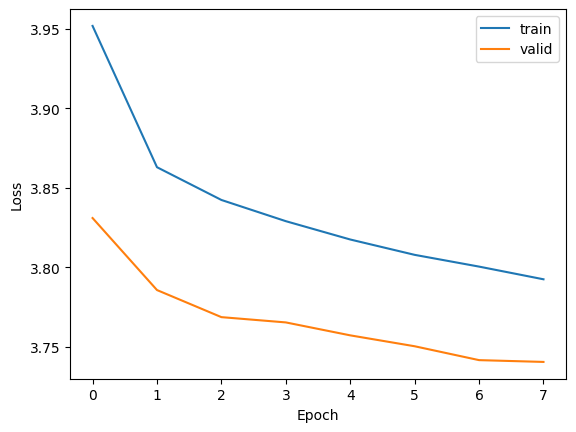

In [ ]:
# Plot train and validation losses of this part of the training procedure
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

In [ ]:
print(model.summary())

Model: "clip_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_encoder_1 (ImageEnco  multiple                  23587712  
 der)                                                            
                                                                 
 text_encoder_1 (TextEncode  multiple                  28763648  
 r)                                                              
                                                                 
 projection_head (Projectio  multiple                  1312768   
 nHead)                                                          
                                                                 
 projection_head_1 (Project  multiple                  526336    
 ionHead)                                                        
                                                                 
Total params: 54190466 (206.72 MB)
Trainable params: 183

### Second part of the training (fine-tuning)

In [ ]:
# Set all the layers of the encoders as trainable
model.image_encoder.model.trainable = True
model.text_encoder.bert_layer.trainable = True

In [ ]:
CFG.trainable = True

In [ ]:
# Update the name of the encoders parameters
model.update_encoder_param_names()

In [ ]:
# Re-compile the model
model.compile(optimizer=clip_optimizer)

# Apply the proper optimizer to the encoders
model.image_encoder.compile(optimizer=encoders_optimizer)
model.text_encoder.compile(optimizer=encoders_optimizer)

In [ ]:
print(model.summary())

Model: "clip_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_encoder_1 (ImageEnco  multiple                  23587712  
 der)                                                            
                                                                 
 text_encoder_1 (TextEncode  multiple                  28763648  
 r)                                                              
                                                                 
 projection_head (Projectio  multiple                  1312768   
 nHead)                                                          
                                                                 
 projection_head_1 (Project  multiple                  526336    
 ionHead)                                                        
                                                                 
Total params: 54190466 (206.72 MB)
Trainable params: 541

In [ ]:
# Fine-tuning
print(f"Number of examples (caption-image pairs): {train_samples}")
print(f"Batch size: {CFG.batch_size}")
print(f"Steps per epoch: {int(np.ceil(train_samples / CFG.batch_size))}")



history = model.fit(
    train_dataset,
    epochs=CFG.epochs - CFG.initial_epochs,
    validation_data=valid_dataset,
    callbacks=[early_stopping,
               model_checkpoint_callback,
               SaveLastEpoch(),
               PrintLRCallback()
               ]
)



print("Training completed. Saving CLIP model...")
model.save(os.path.join(model_path, "clip_model_v3"))
print("The model is saved.")

Number of examples (caption-image pairs): 65415
Batch size: 64
Steps per epoch: 1023
Epoch 1/17
   1023/Unknown - 365s 349ms/step - loss: 3.6903Saved last epoch:1
Learning Rate at the end of epoch 1 : 0.0003643
1023/1023 [==============================] - 408s 392ms/step - loss: 3.6903 - val_loss: 3.5988
Epoch 2/17
1023/1023 [==============================] - ETA: 0s - loss: 3.6249Saved last epoch:2
Learning Rate at the end of epoch 2 : 0.0003358
1023/1023 [==============================] - 404s 387ms/step - loss: 3.6249 - val_loss: 3.5589
Epoch 3/17
1023/1023 [==============================] - ETA: 0s - loss: 3.5946Saved last epoch:3
Learning Rate at the end of epoch 3 : 0.0003060
1023/1023 [==============================] - 402s 386ms/step - loss: 3.5946 - val_loss: 3.5423
Epoch 4/17
1023/1023 [==============================] - ETA: 0s - loss: 3.5749Saved last epoch:4
Learning Rate at the end of epoch 4 : 0.0002754
1023/1023 [==============================] - 402s 385ms/step - loss: 

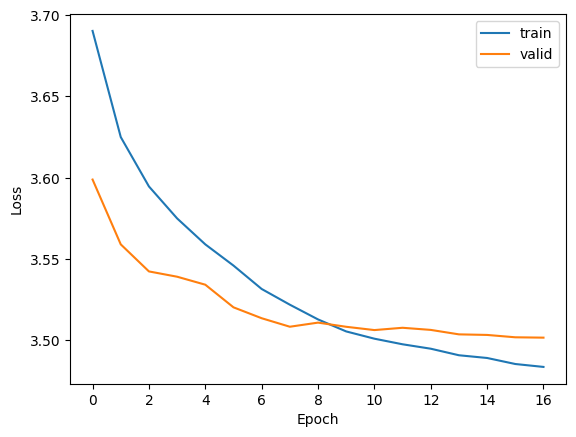

In [ ]:
# Plot losses
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

## Models v2, v4 and v4+

In [ ]:
# run this only if you want to train model v2

def tokenize_map_function(caption):
    encoded = tokenizer.encode_plus(
        caption.numpy().decode('utf-8'),
        add_special_tokens=True,
        max_length=CFG.max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True
    )
    return encoded['input_ids'], encoded['attention_mask']


def preprocess_function(image_path, caption):
    # Text tokenization
    input_ids, attention_mask = tf.py_function(
        tokenize_map_function,
        [caption],
        [tf.int32, tf.int32]
    )
    input_ids.set_shape([CFG.max_length])
    attention_mask.set_shape([CFG.max_length])

    # Images pre-processing (normalize images in the [-1,1] range)
    image_file = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image_file, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5

    return {'input_ids': input_ids, 'attention_mask': attention_mask,
            'image': image}

In [ ]:
# Datasets creation (only for model v2)
train_dataset = tf.data.Dataset.from_tensor_slices((train_dataframe['image'],
                                                    train_dataframe['caption']))
train_dataset = train_dataset.map(preprocess_function).shuffle(
    CFG.buffer_size
    ).prefetch(
        buffer_size=tf.data.AUTOTUNE
        ).batch(
            CFG.batch_size
            )


valid_dataset = tf.data.Dataset.from_tensor_slices((valid_dataframe['image'],
                                                    valid_dataframe['caption']))
valid_dataset = valid_dataset.map(preprocess_function).shuffle(
    CFG.buffer_size
    ).prefetch(
        buffer_size=tf.data.AUTOTUNE
        ).batch(
            CFG.batch_size
            )

In [7]:
# The second version of the CLIP model includes the following image encoder:
# A ViT-small model from Hugging Face transformers library

class ImageEncoder(tf.keras.Model):
    """
    Encode images to a fixed size vector using a smaller Vision Transformer (ViT)
    """
    def __init__(self, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super(ImageEncoder, self).__init__()

        # Upload ViT-small from Hugging Face
        self.model = TFAutoModel.from_pretrained('WinKawaks/vit-small-patch16-224',
                                                 trainable=trainable)
        self.model.trainable = trainable

        if not pretrained:
            self.model.init_weights()


    def call(self, x):
        x = tf.transpose(x, perm=[0, 3, 1, 2])
        outputs = self.model(x)
        return outputs.last_hidden_state[:, 0]

In [18]:
image_encoder = ImageEncoder(trainable=True)
image_encoder.build(input_shape=(None, 224, 224, 3))


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
print(image_encoder.summary())

Model: "image_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_vi_t_model (TFViTModel)  multiple                  21813504  
                                                                 
Total params: 21813504 (83.21 MB)
Trainable params: 21813504 (83.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
# This is the text encoder architecture that we will use for all the versions
# of CLIP: a 4-layers BERT-small architecture from Hugging Face Transformers
# library

class TextEncoder(tf.keras.Model):
    """
    Encode text to a fixed size vector using Small BERT from Hugging Face Transformers
    """
    def __init__(self, model_name=CFG.text_url,
                 trainable=CFG.trainable):
        super(TextEncoder, self).__init__()
        self.bert_layer = TFBertModel.from_pretrained(model_name,
                                                      from_pt=True,
                                                      trainable=trainable)
        self.bert_layer.trainable = trainable


    def call(self, input_ids, attention_mask):
        token_type_ids = tf.zeros_like(input_ids)
        outputs = self.bert_layer(input_ids, attention_mask=attention_mask,
                                  token_type_ids=token_type_ids)
        return outputs.pooler_output

In [21]:
text_encoder = TextEncoder(trainable=False)

pytorch_model.bin:   0%|          | 0.00/116M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [22]:
# Pass a dummy input to the model to build it and be able to print the summary
example_input_ids = tf.random.uniform([1, 200], dtype=tf.int32, minval=0,
                                      maxval=100)
example_attention_mask = tf.random.uniform([1, 200], dtype=tf.int32, minval=0,
                                           maxval=1)

_ = text_encoder(example_input_ids, example_attention_mask)

In [23]:
print(text_encoder.summary())

Model: "text_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model (TFBertModel  multiple                  28763648  
 )                                                               
                                                                 
Total params: 28763648 (109.72 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 28763648 (109.72 MB)
_________________________________________________________________
None


In [9]:
# The projection head is used to transform the image and the text embeddings
#to the same embedding space with the same dimensionality

class ProjectionHead(tf.keras.Model):
    def __init__(self, num_projection_layers=CFG.num_projection_layers,
                 projection_dims=CFG.projection_dim, dropout_rate=CFG.dropout):
        super(ProjectionHead, self).__init__()
        self.projection_layers = tf.keras.Sequential()
        self.projection_layers.add(layers.Dense(units=projection_dims,
                                                activation="relu"))

        for _ in range(num_projection_layers - 1):
            self.projection_layers.add(layers.LayerNormalization(epsilon=1e-5))
            self.projection_layers.add(layers.Dense(projection_dims,
                                                    activation="relu"))
            self.projection_layers.add(layers.Dropout(dropout_rate))


    def call(self, inputs, training=False):
        return self.projection_layers(inputs, training=training)

In [25]:
# Class of the clip model v2/v4/v4+
class CLIPModel(tf.keras.Model):
    def __init__(self, temperature=CFG.temperature,
                 projection_dim=CFG.projection_dim):


        super(CLIPModel, self).__init__()
        self.image_encoder = ImageEncoder(trainable=False)
        self.text_encoder = TextEncoder(trainable=False)
        self.image_projection = ProjectionHead()
        self.text_projection = ProjectionHead()
        self.temperature = temperature
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.encoder_param_names = set()


    @property
    def metrics(self):
        return [self.loss_tracker]


    def call(self, inputs, training=False):
        # Extract features
        image_features = self.image_encoder(inputs['image'], training=training)
        text_features = self.text_encoder(inputs['input_ids'],
                                          inputs['attention_mask'],
                                          training=training)

        # Project features
        image_embeddings = self.image_projection(image_features,
                                                 training=training)
        text_embeddings = self.text_projection(text_features,
                                               training=training)

        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)
        text_embeddings = tf.math.l2_normalize(text_embeddings, axis=1)


        return text_embeddings, image_embeddings


    def compute_loss(self, text_embeddings, image_embeddings):
        # Compute logits
        logits = tf.matmul(text_embeddings, image_embeddings,
                           transpose_b=True) * tf.exp(self.temperature)

        # Prepare the targets for the softmax
        labels = tf.range(tf.shape(logits)[0], dtype=tf.int32)

        # Compute the loss
        loss_i = tf.keras.losses.sparse_categorical_crossentropy(labels,
                                                                 logits,
                                                                 from_logits=True
                                                                 )
        loss_t = tf.keras.losses.sparse_categorical_crossentropy(labels,
                                                                 tf.transpose(
                                                                     logits
                                                                     ),
                                                                 from_logits=True
                                                                 )
        loss = (loss_i + loss_t) / 2.0
        return loss



    def update_encoder_param_names(self):
        self.encoder_param_names = {
            param.name for param in get_encoder_params(self)
            }



    def train_step(self, features):
        with tf.GradientTape() as tape:
            # Forward pass
            caption_embeddings, image_embeddings = self(features, training=True)
            loss = self.compute_loss(caption_embeddings, image_embeddings)

        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # Prepare lists for encoders gradients and other parameters gradients
        encoder_grads = []
        other_grads = []

        # Separate the gradients
        for grad, param in zip(gradients, self.trainable_variables):
            if encoder_image_identifier in param.name or encoder_text_identifier in param.name:
                encoder_grads.append(grad)
            else:
                other_grads.append(grad)

        # Apply gradients
        encoders_optimizer.apply_gradients(zip(encoder_grads,
         [param for param in self.trainable_variables if param.name in self.encoder_param_names])
        )

        clip_optimizer.apply_gradients(zip(other_grads,
         [param for param in self.trainable_variables if param.name not in self.encoder_param_names])
        )

        # keep track of the loss
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}



    def test_step(self, features):
        caption_embeddings, image_embeddings = self(features, training=False)
        loss = self.compute_loss(caption_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [26]:
# Obtain trainable parameters of the encoder
def get_encoder_params(model):
    image_encoder_params = model.image_encoder.trainable_variables
    text_encoder_params = model.text_encoder.trainable_variables
    return image_encoder_params + text_encoder_params

In [27]:
# Apply different learning rate schedules for encoders and the rest of the CLIP
# model (exponential decay for the encoders and cosine decay for the rest of
# the model) and different optimizers (encoders have no weight decay)

clip_lr_schedule = CosineDecay(initial_learning_rate=CFG.head_lr,
                          decay_steps=CFG.decay_steps - CFG.warmup_steps,
                          alpha=CFG.alpha,
                          warmup_target=CFG.warmup_target,
                          warmup_steps=CFG.warmup_steps)


encoders_lr_schedule = ExponentialDecay(initial_learning_rate=CFG.encoders_lr,
                                        decay_steps=CFG.exp_decay_steps,
                                        decay_rate=CFG.exp_decay_rate)


clip_optimizer = tf.keras.optimizers.Adam(learning_rate=clip_lr_schedule,
                                         epsilon=CFG.adam_epsilon,
                                         weight_decay=CFG.weight_decay)

encoders_optimizer = tf.keras.optimizers.Adam(learning_rate=encoders_lr_schedule,
                                              epsilon=CFG.adam_epsilon
                                              )

### First part of the training (non trainable parameters)

In [28]:
# We need these identifiers to manually separate the encoder parameters to the
# other ones

encoder_image_identifier = 'vit'
encoder_text_identifier = 'bert'

In [29]:
model = CLIPModel()
model.compile(optimizer=clip_optimizer)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerN

In [30]:
# Callback to print learning rate
class PrintLRCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if hasattr(self.model.optimizer, 'lr'):
            lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
            print(f"Learning Rate at the end of epoch {epoch + 1} : {lr:.7f}")

In [31]:
# Check if there are saved weights
if os.path.exists(checkpoint_path):
    model.built = True
    model.load_weights(checkpoint_path)
    print("Loaded model weights from:", checkpoint_path)


# Check if there is a saved last epoch
if os.path.exists(last_epoch_path):
    with open(last_epoch_path, 'r') as file:
        last_epoch = int(file.read())
    print("Resuming training from epoch:" + str(last_epoch + 1))
else:
    last_epoch = 0


# Define a ModelCheckpoint callback to save the best model weights
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=False,  # Save only the best model based on the monitored
                          # quantity (val_loss in this case)
    monitor='val_loss',  # Monitor validation loss
    save_weights_only=True # Save only the model weights
)


# Define a callback to save the last epoch reached
class SaveLastEpoch(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        with open(last_epoch_path, 'w') as file:
            file.write(str(epoch + 1))
        print("Saved last epoch:" + str(epoch + 1))

In [32]:
print(f"Number of examples (caption-image pairs): {train_samples}")
print(f"Batch size: {CFG.batch_size}")
print(f"Steps per epoch: {int(np.ceil(train_samples / CFG.batch_size))}")


# Create an early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=CFG.patience_stop, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    epochs=CFG.initial_epochs,
    validation_data=valid_dataset,
    callbacks=[early_stopping,
               model_checkpoint_callback, # Include the ModelCheckpoint callback
               SaveLastEpoch(),
               PrintLRCallback() # Include the SaveLastEpoch callback
               ]
)

Number of examples (caption-image pairs): 65415
Batch size: 64
Steps per epoch: 1023
Epoch 1/8
   1023/Unknown - 205s 171ms/step - loss: 3.9836Saved last epoch:1
Learning Rate at the end of epoch 1 : 0.0004988
1023/1023 [==============================] - 260s 224ms/step - loss: 3.9836 - val_loss: 3.8558
Epoch 2/8
1022/1023 [============================>.] - ETA: 0s - loss: 3.9026Saved last epoch:2
Learning Rate at the end of epoch 2 : 0.0004937
1023/1023 [==============================] - 237s 223ms/step - loss: 3.9024 - val_loss: 3.8141
Epoch 3/8
1022/1023 [============================>.] - ETA: 0s - loss: 3.8774Saved last epoch:3
Learning Rate at the end of epoch 3 : 0.0004849
1023/1023 [==============================] - 234s 220ms/step - loss: 3.8771 - val_loss: 3.7888
Epoch 4/8
1022/1023 [============================>.] - ETA: 0s - loss: 3.8649Saved last epoch:4
Learning Rate at the end of epoch 4 : 0.0004725
1023/1023 [==============================] - 237s 222ms/step - loss: 3.86

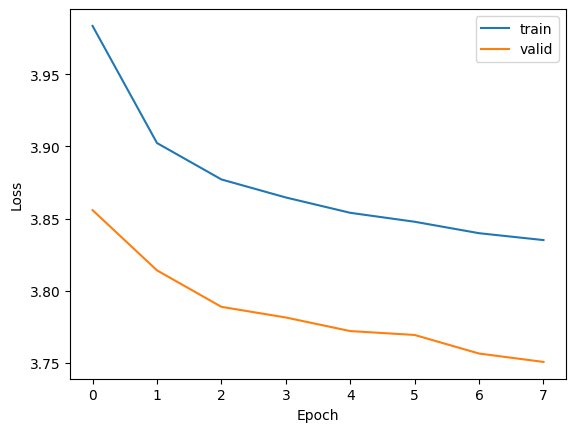

In [33]:
# Plot train and validation losses of this part of the training procedure
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

In [34]:
print(model.summary())

Model: "clip_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_encoder_1 (ImageEnco  multiple                  21813504  
 der)                                                            
                                                                 
 text_encoder_1 (TextEncode  multiple                  28763648  
 r)                                                              
                                                                 
 projection_head (Projectio  multiple                  460800    
 nHead)                                                          
                                                                 
 projection_head_1 (Project  multiple                  526336    
 ionHead)                                                        
                                                                 
Total params: 51564290 (196.70 MB)
Trainable params: 987

### Second part of the training (fine-tuning)

In [35]:
# Set all the layers of the encoders as trainable
model.image_encoder.model.trainable = True
model.text_encoder.bert_layer.trainable = True

In [36]:
CFG.trainable = True

In [37]:
# Update the name of the encoders parameters
model.update_encoder_param_names()

In [38]:
# Re-compile the model
model.compile(optimizer=clip_optimizer)

# Apply the proper optimizer to the encoders
model.text_encoder.compile(optimizer=encoders_optimizer)
model.image_encoder.compile(optimizer=encoders_optimizer)

In [39]:
print(model.summary())

Model: "clip_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_encoder_1 (ImageEnco  multiple                  21813504  
 der)                                                            
                                                                 
 text_encoder_1 (TextEncode  multiple                  28763648  
 r)                                                              
                                                                 
 projection_head (Projectio  multiple                  460800    
 nHead)                                                          
                                                                 
 projection_head_1 (Project  multiple                  526336    
 ionHead)                                                        
                                                                 
Total params: 51564290 (196.70 MB)
Trainable params: 515

In [40]:
# Fine-tuning
print(f"Number of examples (caption-image pairs): {train_samples}")
print(f"Batch size: {CFG.batch_size}")
print(f"Steps per epoch: {int(np.ceil(train_samples / CFG.batch_size))}")



history = model.fit(
    train_dataset,
    epochs=CFG.epochs - CFG.initial_epochs,
    validation_data=valid_dataset,
    callbacks=[early_stopping,
               model_checkpoint_callback,
               SaveLastEpoch(),
               PrintLRCallback()
               ]
)



print("Training completed. Saving CLIP model...")
model.save(os.path.join(model_path, "clip_model_v4"))
print("The model is saved.")

Number of examples (caption-image pairs): 65415
Batch size: 64
Steps per epoch: 1023
Epoch 1/17


   1023/Unknown - 506s 432ms/step - loss: 3.7166Saved last epoch:1
Learning Rate at the end of epoch 1 : 0.0003644
1023/1023 [==============================] - 563s 488ms/step - loss: 3.7166 - val_loss: 3.5992
Epoch 2/17
1023/1023 [==============================] - ETA: 0s - loss: 3.6535Saved last epoch:2
Learning Rate at the end of epoch 2 : 0.0003359
1023/1023 [==============================] - 502s 481ms/step - loss: 3.6535 - val_loss: 3.5597
Epoch 3/17
1023/1023 [==============================] - ETA: 0s - loss: 3.6234Saved last epoch:3
Learning Rate at the end of epoch 3 : 0.0003061
1023/1023 [==============================] - 501s 481ms/step - loss: 3.6234 - val_loss: 3.5557
Epoch 4/17
1023/1023 [==============================] - ETA: 0s - loss: 3.6026Saved last epoch:4
Learning Rate at the end of epoch 4 : 0.0002754
1023/1023 [==============================] - 503s 482ms/step - loss: 3.6026 - val_loss: 3.5250
Epoch 5/17
1023/1023 [==============================] - ETA: 0s - loss

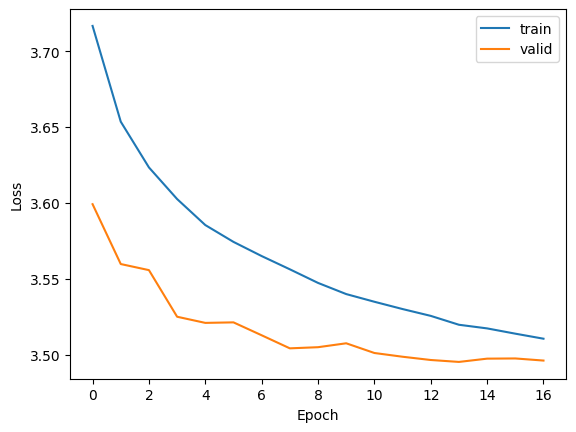

In [42]:
# Plot losses
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

## Image retrieval

In [10]:
# Load the model
custom_objects = {
    'ImageEncoder': ImageEncoder,
    'TextEncoder': TextEncoder,
    'ProjectionHead': ProjectionHead
}


# Change the first parameter basing on the version you want to import
model = tf.keras.models.load_model(os.path.join(model_path,
                                                "clip_model_v4_plus"),
                                   custom_objects)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


pytorch_model.bin:   0%|          | 0.00/116M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [ ]:
# Function to create the image embeddings (for model v1 and model v3)
def get_image_embeddings(model, image_paths, batch_size=CFG.batch_size):
    image_embeddings = []

    for i in range(0, len(image_paths), batch_size):
        print("Generating embedding for image n° {}".format(i))
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []

        for image_path in batch_paths:
            image_file = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image_file, channels=3)
            image = tf.image.resize(image, [CFG.size, CFG.size])
            image = tf.keras.applications.resnet.preprocess_input(image)
            batch_images.append(image)

        batch_images = tf.stack(batch_images, axis=0)
        image_features = model.image_encoder(batch_images, training=False)
        batch_embeddings = model.image_projection(image_features)
        image_embeddings.extend(batch_embeddings)

    final_embeddings = tf.stack(image_embeddings, axis=0)
    return final_embeddings

In [11]:
# Function to create the image embeddings (for models v2 and v4)
def get_image_embeddings(model, image_paths, batch_size=CFG.batch_size):
    image_embeddings = []

    for i in range(0, len(image_paths), batch_size):
        print("Generating embedding for image n° {}".format(i))
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []

        for image_path in batch_paths:
            image_file = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image_file, channels=3)
            image = tf.image.resize(image, [224, 224])
            image = tf.cast(image, tf.float32)
            image = (image - 127.5) / 127.5
            batch_images.append(image)

        batch_images = tf.stack(batch_images, axis=0)
        image_features = model.image_encoder(batch_images, training=False)
        batch_embeddings = model.image_projection(image_features)
        image_embeddings.extend(batch_embeddings)

    final_embeddings = tf.stack(image_embeddings, axis=0)
    return final_embeddings

In [20]:
# Change the second parameters basing on the dataset on which you want to test
# the model

image_embeddings = get_image_embeddings(model, data_image_paths)

Generating embedding for image n° 0
Generating embedding for image n° 64
Generating embedding for image n° 128
Generating embedding for image n° 192
Generating embedding for image n° 256
Generating embedding for image n° 320
Generating embedding for image n° 384
Generating embedding for image n° 448
Generating embedding for image n° 512
Generating embedding for image n° 576
Generating embedding for image n° 640
Generating embedding for image n° 704
Generating embedding for image n° 768
Generating embedding for image n° 832
Generating embedding for image n° 896
Generating embedding for image n° 960
Generating embedding for image n° 1024
Generating embedding for image n° 1088
Generating embedding for image n° 1152
Generating embedding for image n° 1216
Generating embedding for image n° 1280
Generating embedding for image n° 1344
Generating embedding for image n° 1408
Generating embedding for image n° 1472
Generating embedding for image n° 1536
Generating embedding for image n° 1600
Gener

In [21]:
print(image_embeddings.shape)

(83275, 512)


In [ ]:
# function to find matches between the given image dataset and a given query
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    # Tokenize the query
    tokenizer = BertTokenizer.from_pretrained(CFG.text_url)
    input_ids, attention_mask = tf.py_function(
        tokenize_map_function,
        [query],
        [tf.int32, tf.int32]
    )
    input_ids.set_shape([CFG.max_length])
    attention_mask.set_shape([CFG.max_length])

    # Add an other dimension to match what the model expects
    input_ids = tf.expand_dims(input_ids, 0)
    attention_mask = tf.expand_dims(attention_mask, 0)

    # Retrieve text features
    text_features = model.text_encoder(
        input_ids=input_ids, attention_mask=attention_mask, training=False
    )

    # Retrieve text embeddings
    text_embeddings = model.text_projection(text_features)

    # Normalize embeddings
    image_embeddings_n = tf.math.l2_normalize(image_embeddings, axis=1)
    text_embeddings_n = tf.math.l2_normalize(text_embeddings, axis=1)

    dot_similarity = tf.matmul(text_embeddings_n, image_embeddings_n,
                               transpose_b=True)

    values, indices = tf.math.top_k(tf.squeeze(dot_similarity), k=n * 5)

    # Find matches
    matches = [image_filenames[idx] for idx in indices.numpy()[::5]]

    # Plot matches
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(match)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

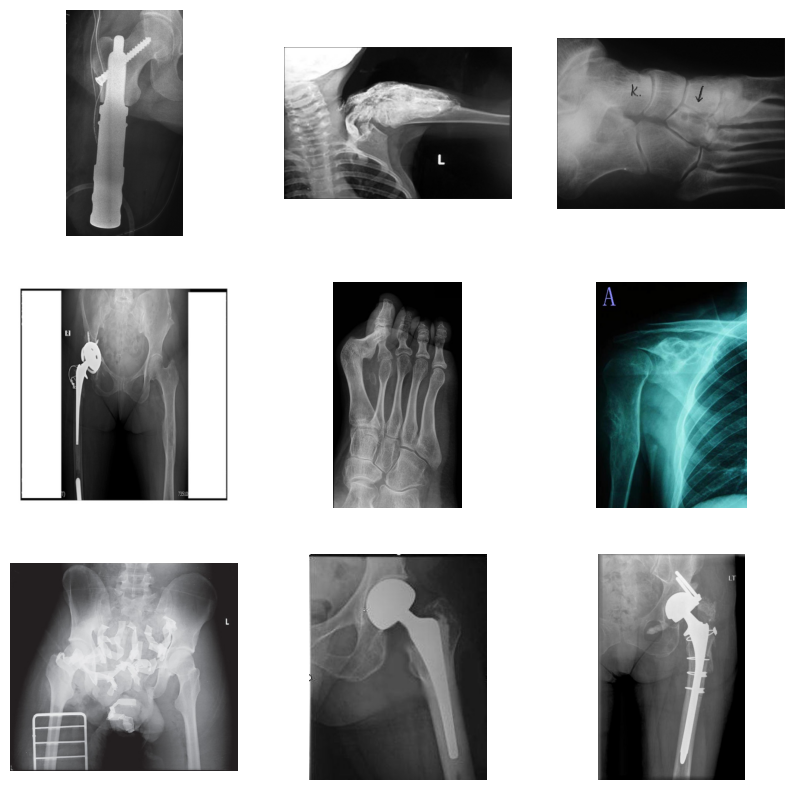

In [ ]:
# Change this basing on your query for image retrieval
query = "leg x-ray"

# Change the last parameter basing on your dataset
matches = find_matches(model, image_embeddings, query, data_image_paths)

## Text retrieval

In [ ]:
# Load the model
custom_objects = {
    'ImageEncoder': ImageEncoder,
    'TextEncoder': TextEncoder,
    'ProjectionHead': ProjectionHead
}


# Change this basing on the version you want to import
model = tf.keras.models.load_model(os.path.join(model_path, "clip_model_v1"),
                                   custom_objects)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [12]:
# Function to create text embeddings
def get_text_embeddings(model, captions, batch_size=CFG.batch_size):
    tokenizer = BertTokenizer.from_pretrained(CFG.text_url)
    text_embeddings = []

    for i in range(0, len(captions), batch_size):
        print("Generating embedding for text n° {}".format(i))
        batch_captions = captions[i:i + batch_size]

        # Tokenization of batches of texts
        encoded_batch = tokenizer.batch_encode_plus(
            batch_captions,
            max_length=CFG.max_length,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors="tf"
        )

        # Extract input_ids and attention masks
        input_ids = encoded_batch['input_ids']
        attention_mask = encoded_batch['attention_mask']

        # Process texts
        text_features = model.text_encoder(
            input_ids=input_ids, attention_mask=attention_mask, training=False
        )
        batch_embeddings = model.text_projection(text_features)
        text_embeddings.extend(batch_embeddings)

    final_embeddings = tf.stack(text_embeddings, axis=0)
    return final_embeddings

In [ ]:
# Change the second parameters basing on the dataset on which you want to test
# the model

text_embeddings = get_text_embeddings(model, data_captions)

Generating embedding for text n° 0
Generating embedding for text n° 64
Generating embedding for text n° 128
Generating embedding for text n° 192
Generating embedding for text n° 256
Generating embedding for text n° 320
Generating embedding for text n° 384
Generating embedding for text n° 448
Generating embedding for text n° 512
Generating embedding for text n° 576
Generating embedding for text n° 640
Generating embedding for text n° 704
Generating embedding for text n° 768
Generating embedding for text n° 832
Generating embedding for text n° 896
Generating embedding for text n° 960
Generating embedding for text n° 1024
Generating embedding for text n° 1088
Generating embedding for text n° 1152
Generating embedding for text n° 1216
Generating embedding for text n° 1280
Generating embedding for text n° 1344
Generating embedding for text n° 1408
Generating embedding for text n° 1472
Generating embedding for text n° 1536
Generating embedding for text n° 1600
Generating embedding for text n

In [ ]:
print(text_embeddings.shape)

(16655, 512)


In [ ]:
# find text matches for the given image query (only for models v1 and v3)

def find_matches(model, text_embeddings, image_path, captions, n=9):
    # Image pre-processing
    image_file = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image_file, channels=3)
    image = tf.image.resize(image, [CFG.size, CFG.size])
    image = tf.keras.applications.resnet.preprocess_input(image)

    # Add a batch dimension
    image = tf.expand_dims(image, 0)

    # Compute the embeddings for the query image
    image_features = model.image_encoder(image, training=False)
    image_embedding = model.image_projection(image_features)

    # Normalize embeddings
    image_embedding_n = tf.math.l2_normalize(image_embedding, axis=1)
    text_embeddings_n = tf.math.l2_normalize(text_embeddings, axis=1)

    # Compute similarity
    dot_similarity = tf.matmul(image_embedding_n, text_embeddings_n,
                               transpose_b=True)

    # Find the most n relevant captions
    values, indices = tf.math.top_k(tf.squeeze(dot_similarity), k=n)

    # Extract matches
    matches = [captions[idx] for idx in indices.numpy()]

    # Plot the query image
    print("Here there is the query image:")
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    print("Here there are the most relevant captions: \n")
    # Print the top n matching queries
    for match in matches:
        print("- " + match)

    return matches

In [ ]:
# find text matches for the given image query (only for models v2 and v4)

def find_matches(model, text_embeddings, image_path, captions, n=9):
    # Image pre-processing
    image_file = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image_file, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5

    # Add a batch dimension
    image = tf.expand_dims(image, 0)

    # Compute the embeddings for the query image
    image_features = model.image_encoder(image, training=False)
    image_embedding = model.image_projection(image_features)

    # Normalize embeddings
    image_embedding_n = tf.math.l2_normalize(image_embedding, axis=1)
    text_embeddings_n = tf.math.l2_normalize(text_embeddings, axis=1)

    # Compute similarity
    dot_similarity = tf.matmul(image_embedding_n, text_embeddings_n,
                               transpose_b=True)

    # Find the most n relevant captions
    values, indices = tf.math.top_k(tf.squeeze(dot_similarity), k=n)

    # Extract matches
    matches = [captions[idx] for idx in indices.numpy()]

    # Plot the query image
    print("Here there is the query image:")
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    print("Here there are the most relevant captions: \n")
    # Print the top n matching queries
    for match in matches:
        print("- " + match)

    return matches

Here there is the query image:


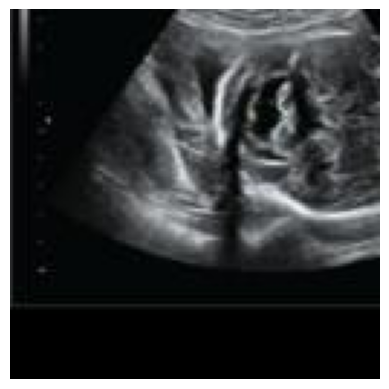

Here there are the most relevant captions: 

- right upper quadrant ultrasoundcommon bile duct ultrasonographic image at the time of presentation reveal a mildly dilated common bile duct measure  mm in diameter
- right upper quadrant ultrasound read as a  gallbladder wall and echogenic gallstone without pericholecystic fluid murphys sign or common bile duct cbd dilation  cbd
- case  leg ultrasound show thrombus in left saphenofemoral vein
- preoperative ultrasound with color power doppler  show no vascularity so this case be diagnose as cyst
- follow up color doppler ultrasound show no evidence of blood flow within the pseudoaneurysm
- transabdominal ultrasound do in  show focal thickening at low uterine segment with vascularity suggestive of a polyp
- typical oligocystic serous pancreatic neoplasia use endoscopic ultrasound
- ultrasound scan picture show the fusiform dilatation of the common bile duct
- longitudinal cut ultrasound show a quiet appendice horizontal flush diameter measu

In [ ]:
# Change these basing on your query for text retrieval and on your dataset

query = valid_image_paths[np.random.choice(range(len(valid_image_paths)))]
matches = find_matches(model, text_embeddings, query, valid_captions)

## Compute metrics

### Performance on concepts

In [22]:
# function to find matches between the given image dataset and a given batch of
# queries (we use this function to compute metrics)

def find_batch_matches(model, image_embeddings, queries, image_filenames, n=9):
    tokenizer = BertTokenizer.from_pretrained(CFG.text_url)

    # Batch tokenization of queries
    encoded_queries = tokenizer.batch_encode_plus(
        queries,
        max_length=CFG.max_length,
        add_special_tokens=True,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors="tf"
    )

    # Extract input ids and attention masks
    input_ids = encoded_queries['input_ids']
    attention_mask = encoded_queries['attention_mask']

    # Process queries
    text_features = model.text_encoder(
        input_ids=input_ids, attention_mask=attention_mask, training=False
    )
    text_embeddings = model.text_projection(text_features)

    image_embeddings_n = tf.math.l2_normalize(image_embeddings, axis=1)
    text_embeddings_n = tf.math.l2_normalize(text_embeddings, axis=1)

    dot_similarity = tf.matmul(text_embeddings_n, image_embeddings_n,
                               transpose_b=True)

    # Find matches for each query
    all_matches = []
    for i in range(dot_similarity.shape[0]):
        values, indices = tf.math.top_k(dot_similarity[i], k=n)
        matches = [image_filenames[idx] for idx in indices.numpy()]
        all_matches.append(matches)

    return all_matches

In [23]:
# Test model on the concepts dataset (related to the original images)
concepts_name = pd.read_csv(concepts_name_path, delimiter='\t')
print(concepts_name.describe)

<bound method NDFrame.describe of        concept                          concept_name
0     C2825493                  Non-Enhancing Lesion
1     C0922672                  Right lateral rectus
2     C1167956     Cardiac Resynchronization Therapy
3     C0030288                       Pancreatic duct
4     C0815700              Right obturator internus
...        ...                                   ...
8369  C0016202                              Flatfoot
8370  C0226093  Structure of superior thyroid artery
8371  C3890422  Post-Treatment Lyme Disease Syndrome
8372  C0025344                          Menstruation
8373  C0231462                     External rotation

[8374 rows x 2 columns]>


In [24]:
concepts = pd.read_csv(concepts_path, delimiter='\t')
print(concepts.describe)

<bound method NDFrame.describe of                                           ID  \
0      ImageCLEFmedCaption_2022_train_000001   
1      ImageCLEFmedCaption_2022_train_000002   
2      ImageCLEFmedCaption_2022_train_000003   
3      ImageCLEFmedCaption_2022_train_000004   
4      ImageCLEFmedCaption_2022_train_000005   
...                                      ...   
83270  ImageCLEFmedCaption_2022_train_084253   
83271  ImageCLEFmedCaption_2022_train_084254   
83272  ImageCLEFmedCaption_2022_train_084255   
83273  ImageCLEFmedCaption_2022_train_084256   
83274  ImageCLEFmedCaption_2022_train_084257   

                                                    cuis  
0                             C0002978;C0007177;C0031050  
1           C0002978;C0003489;C0175631;C0443127;C0226261  
2      C0002978;C0021102;C0085590;C0232180;C0205197;C...  
3                    C0002978;C0013931;C0178866;C1510412  
4                             C0002978;C0205100;C0226463  
...                                

In [25]:
# Reverse mapping: we create, for each concept, a list of images
# associated to it

concept_to_images = {}
for i in concepts.index.values:
    image_id = concepts.iloc[i]['ID']
    concept_list = concepts.iloc[i]['cuis'].split(';')
    for concept in concept_list:
        if concept in concept_to_images:
            concept_to_images[concept].append("content/resized_train/" +
                                              image_id + ".jpg")
        else:
            concept_to_images[concept] = ["content/resized_train/" +
                                          image_id + ".jpg"]


# Add the list of images to the corresponding concept in the dataframe
concepts_name['image_IDs'] = concepts_name['concept'].apply(
    lambda x: concept_to_images.get(x, [])
    )

# Print the dataframe
print(concepts_name)

       concept                          concept_name  \
0     C2825493                  Non-Enhancing Lesion   
1     C0922672                  Right lateral rectus   
2     C1167956     Cardiac Resynchronization Therapy   
3     C0030288                       Pancreatic duct   
4     C0815700              Right obturator internus   
...        ...                                   ...   
8369  C0016202                              Flatfoot   
8370  C0226093  Structure of superior thyroid artery   
8371  C3890422  Post-Treatment Lyme Disease Syndrome   
8372  C0025344                          Menstruation   
8373  C0231462                     External rotation   

                                              image_IDs  
0     [content/resized_train/ImageCLEFmedCaption_202...  
1     [content/resized_train/ImageCLEFmedCaption_202...  
2     [content/resized_train/ImageCLEFmedCaption_202...  
3     [content/resized_train/ImageCLEFmedCaption_202...  
4     [content/resized_train/ImageCLE

In [26]:
# Function to compute the metrics (Accuracy, nDCG and MRR at k)

def calculate_metrics_at_k(model, image_embeddings, concept_names_df,
                           image_filenames, k=9, batch_size=CFG.batch_size):
    correct_matches = 0
    ndcg_scores = []
    mrr_scores = []

    for batch_start in range(0, len(concept_names_df), batch_size):
        print("Processing the concept n° {}".format(batch_start))
        batch_concepts = concept_names_df.iloc[
            batch_start:batch_start + batch_size]
        batch_queries = batch_concepts['concept_name'].tolist()
        batch_query_concept_ids = batch_concepts['concept'].tolist()

        batch_top_k_matches = find_batch_matches(model, image_embeddings,
                                                 batch_queries, image_filenames,
                                                 n=k)

        for i, concept_id in enumerate(batch_query_concept_ids):
            correct_image_ids = concept_names_df[
                concept_names_df['concept'] == concept_id]['image_IDs'].iloc[0]
            top_k_matches = batch_top_k_matches[i]

            # Accuracy@K: Check if at least one correct match is in top K
            if any(match in correct_image_ids for match in top_k_matches):
                correct_matches += 1

            # NDCG@K: Calculate DCG and IDCG
            dcg = 0
            idcg = 0
            for j, match in enumerate(top_k_matches):
                if match in correct_image_ids:
                    dcg += 1 / np.log2(j + 2)  # log2(index+1), index starts from 0
                idcg += 1 / np.log2(j + 2)
            ndcg = dcg / idcg if idcg > 0 else 0
            ndcg_scores.append(ndcg)

            # MRR@K: Calculate reciprocal rank
            for j, match in enumerate(top_k_matches):
                if match in correct_image_ids:
                    mrr_scores.append(1 / (j + 1))
                    break
            else:
                mrr_scores.append(0)

    accuracy_at_k = correct_matches / len(concept_names_df)
    ndcg_at_k = np.mean(ndcg_scores)
    mrr_at_k = np.mean(mrr_scores)

    return accuracy_at_k, ndcg_at_k, mrr_at_k

In [27]:
# Compute and print metrics for the given model
acc_100, ndcg_100, mrr_100 = calculate_metrics_at_k(model, image_embeddings,
                                                    concepts_name,
                                                    data_image_paths, k=100)

print("Here there is the performance of the model with a new set of concepts " +
      "from the original dataset:\n")
print("nDCG@100: ", ndcg_100)
print("MRR@100: ", mrr_100)
print("Accuracy@100: ", acc_100)

Processing the concept n° 0
Processing the concept n° 64
Processing the concept n° 128
Processing the concept n° 192
Processing the concept n° 256
Processing the concept n° 320
Processing the concept n° 384
Processing the concept n° 448
Processing the concept n° 512
Processing the concept n° 576
Processing the concept n° 640
Processing the concept n° 704
Processing the concept n° 768
Processing the concept n° 832
Processing the concept n° 896
Processing the concept n° 960
Processing the concept n° 1024
Processing the concept n° 1088
Processing the concept n° 1152
Processing the concept n° 1216
Processing the concept n° 1280
Processing the concept n° 1344
Processing the concept n° 1408
Processing the concept n° 1472
Processing the concept n° 1536
Processing the concept n° 1600
Processing the concept n° 1664
Processing the concept n° 1728
Processing the concept n° 1792
Processing the concept n° 1856
Processing the concept n° 1920
Processing the concept n° 1984
Processing the concept n° 2

### Performance on a new unseen dataset

In [13]:
# Now we want to test the model performance on a new unseen dataset:
# the Flickr-8k

zip_flickr_path = os.path.join(master_path, "Flickr-8k.zip")
flickr_caption_file = os.path.join(master_path, "Flickr-8k-captions.txt")

In [14]:
# Unzip the folder containing the data
if True:
    !unzip {zip_flickr_path} -d {extraction_path}

Output streaming troncato alle ultime 5000 righe.
  inflating: content/Flickr-8k/2844747252_64567cf14a.jpg  
  inflating: content/Flickr-8k/2844846111_8c1cbfc75d.jpg  
  inflating: content/Flickr-8k/2844963839_ff09cdb81f.jpg  
  inflating: content/Flickr-8k/2845246160_d0d1bbd6f0.jpg  
  inflating: content/Flickr-8k/2845691057_d4ab89d889.jpg  
  inflating: content/Flickr-8k/2845845721_d0bc113ff7.jpg  
  inflating: content/Flickr-8k/2846037553_1a1de50709.jpg  
  inflating: content/Flickr-8k/2846785268_904c5fcf9f.jpg  
  inflating: content/Flickr-8k/2846843520_b0e6211478.jpg  
  inflating: content/Flickr-8k/2847514745_9a35493023.jpg  
  inflating: content/Flickr-8k/2847615962_c330bded6e.jpg  
  inflating: content/Flickr-8k/2847859796_4d9cb0d31f.jpg  
  inflating: content/Flickr-8k/2848266893_9693c66275.jpg  
  inflating: content/Flickr-8k/2848571082_26454cb981.jpg  
  inflating: content/Flickr-8k/2848895544_6d06210e9d.jpg  
  inflating: content/Flickr-8k/2848977044_446a31d86e.jpg  
  infl

In [ ]:
flickr_data = pd.read_csv(flickr_caption_file)
print(flickr_data.describe)

<bound method NDFrame.describe of                            image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                 caption  
0      A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building .  
2       A little girl climbing into a wooden playhouse .  
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451           A man is rock climbing high in the air .  
40

In [ ]:
# Update the image paths
flickr_data['image'] = flickr_data['image'].apply(lambda x:
                                                  "content/Flickr-8k/" + x)
print(flickr_data.describe)

<bound method NDFrame.describe of                                              image  \
0      content/Flickr-8k/1000268201_693b08cb0e.jpg   
1      content/Flickr-8k/1000268201_693b08cb0e.jpg   
2      content/Flickr-8k/1000268201_693b08cb0e.jpg   
3      content/Flickr-8k/1000268201_693b08cb0e.jpg   
4      content/Flickr-8k/1000268201_693b08cb0e.jpg   
...                                            ...   
40450   content/Flickr-8k/997722733_0cb5439472.jpg   
40451   content/Flickr-8k/997722733_0cb5439472.jpg   
40452   content/Flickr-8k/997722733_0cb5439472.jpg   
40453   content/Flickr-8k/997722733_0cb5439472.jpg   
40454   content/Flickr-8k/997722733_0cb5439472.jpg   

                                                 caption  
0      A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building .  
2       A little girl climbing into a wooden playhouse .  
3      A little girl climbing the stairs to her playh...  
4      A little girl i

In [ ]:
# Select just one random caption per image
grouped = flickr_data.groupby('image')['caption']
flickr_data = grouped.apply(lambda x: x.sample(1)).reset_index(level=0)

In [ ]:
print(flickr_data.describe)

<bound method NDFrame.describe of                                              image  \
0      content/Flickr-8k/1000268201_693b08cb0e.jpg   
9      content/Flickr-8k/1001773457_577c3a7d70.jpg   
14     content/Flickr-8k/1002674143_1b742ab4b8.jpg   
17     content/Flickr-8k/1003163366_44323f5815.jpg   
23     content/Flickr-8k/1007129816_e794419615.jpg   
...                                            ...   
40430   content/Flickr-8k/990890291_afc72be141.jpg   
40439    content/Flickr-8k/99171998_7cc800ceef.jpg   
40440    content/Flickr-8k/99679241_adc853a5c0.jpg   
40448   content/Flickr-8k/997338199_7343367d7f.jpg   
40453   content/Flickr-8k/997722733_0cb5439472.jpg   

                                                 caption  
0      A child in a pink dress is climbing up a set o...  
9        Two dogs on pavement moving toward each other .  
14     Young girl with pigtails painting outside in t...  
17     a man sleeping on a bench outside with a white...  
23     A man with glas

In [ ]:
# Save the cleaned dataset to compare models on the same pairs (image, caption)
flickr_data.to_csv(os.path.join(master_path, "flickr_csv"), index=False)

In [15]:
flickr_data = pd.read_csv(os.path.join(master_path, "flickr_csv"))

In [16]:
print(flickr_data.describe)

<bound method NDFrame.describe of                                             image  \
0     content/Flickr-8k/1000268201_693b08cb0e.jpg   
1     content/Flickr-8k/1001773457_577c3a7d70.jpg   
2     content/Flickr-8k/1002674143_1b742ab4b8.jpg   
3     content/Flickr-8k/1003163366_44323f5815.jpg   
4     content/Flickr-8k/1007129816_e794419615.jpg   
...                                           ...   
8086   content/Flickr-8k/990890291_afc72be141.jpg   
8087    content/Flickr-8k/99171998_7cc800ceef.jpg   
8088    content/Flickr-8k/99679241_adc853a5c0.jpg   
8089   content/Flickr-8k/997338199_7343367d7f.jpg   
8090   content/Flickr-8k/997722733_0cb5439472.jpg   

                                                caption  
0     A child in a pink dress is climbing up a set o...  
1       Two dogs on pavement moving toward each other .  
2     Young girl with pigtails painting outside in t...  
3     a man sleeping on a bench outside with a white...  
4     A man with glasses is wearing a b

In [17]:
flickr_images_paths = flickr_data['image'].tolist()

In [18]:
flickr_captions = flickr_data['caption'].tolist()

In [19]:
# Get image embeddings
flickr_image_embeddings = get_image_embeddings(model, flickr_images_paths)

Generating embedding for image n° 0
Generating embedding for image n° 64
Generating embedding for image n° 128
Generating embedding for image n° 192
Generating embedding for image n° 256
Generating embedding for image n° 320
Generating embedding for image n° 384
Generating embedding for image n° 448
Generating embedding for image n° 512
Generating embedding for image n° 576
Generating embedding for image n° 640
Generating embedding for image n° 704
Generating embedding for image n° 768
Generating embedding for image n° 832
Generating embedding for image n° 896
Generating embedding for image n° 960
Generating embedding for image n° 1024
Generating embedding for image n° 1088
Generating embedding for image n° 1152
Generating embedding for image n° 1216
Generating embedding for image n° 1280
Generating embedding for image n° 1344
Generating embedding for image n° 1408
Generating embedding for image n° 1472
Generating embedding for image n° 1536
Generating embedding for image n° 1600
Gener

In [20]:
print(flickr_image_embeddings.shape)

(8091, 512)


In [21]:
# Get text embeddings
flickr_text_embeddings = get_text_embeddings(model, flickr_captions)

Generating embedding for text n° 0
Generating embedding for text n° 64
Generating embedding for text n° 128
Generating embedding for text n° 192
Generating embedding for text n° 256
Generating embedding for text n° 320
Generating embedding for text n° 384
Generating embedding for text n° 448
Generating embedding for text n° 512
Generating embedding for text n° 576
Generating embedding for text n° 640
Generating embedding for text n° 704
Generating embedding for text n° 768
Generating embedding for text n° 832
Generating embedding for text n° 896
Generating embedding for text n° 960
Generating embedding for text n° 1024
Generating embedding for text n° 1088
Generating embedding for text n° 1152
Generating embedding for text n° 1216
Generating embedding for text n° 1280
Generating embedding for text n° 1344
Generating embedding for text n° 1408
Generating embedding for text n° 1472
Generating embedding for text n° 1536
Generating embedding for text n° 1600
Generating embedding for text n

In [22]:
print(flickr_text_embeddings.shape)

(8091, 512)


In [23]:
# Compute the metrics on the new unseen dataset
def calculate_metrics_at_k(image_embeddings, text_embeddings, k=9):
    correct_matches = 0
    mrr_scores = []

    # Similarity between embeddings
    dot_similarity = tf.matmul(text_embeddings, image_embeddings,
                               transpose_b=True)

    # Create an identity matrix of the same shape as dot_similarity
    identity_matrix = tf.eye(dot_similarity.shape[0])

    # Compute cosine similarity between dot_similarity and identity_matrix
    dot_similarity_normalized = tf.nn.l2_normalize(dot_similarity, axis=1)
    identity_matrix_normalized = tf.nn.l2_normalize(identity_matrix, axis=1)
    cosine_similarity = tf.reduce_sum(
        dot_similarity_normalized * identity_matrix_normalized,
        axis=1)

    for i in range(dot_similarity.shape[0]):
        print("Processing the embedding n° {}".format(i))
        values, indices = tf.math.top_k(dot_similarity[i], k)
        top_k_indices = indices.numpy()

        # Check if the correct index (i) is in the first top k
        if i in top_k_indices:
            correct_matches += 1
            rank = np.where(top_k_indices == i)[0][0] + 1

            # Compute MRR@K
            mrr_scores.append(1 / rank)
        else:
            mrr_scores.append(0)

    # Computes the average of the obtained metrics
    accuracy_at_k = correct_matches / dot_similarity.shape[0]
    mrr_at_k = np.mean(mrr_scores)

    # Average cosine similarity across all queries
    average_cosine_similarity = tf.reduce_mean(cosine_similarity)

    return accuracy_at_k, mrr_at_k, average_cosine_similarity.numpy()

In [24]:
# Compute and print metrics for the given model and the new unseen dataset
acc_100, mrr_100, cosine_sim = calculate_metrics_at_k(flickr_image_embeddings,
                                                      flickr_text_embeddings,
                                                      k=100)

print("Here there is the zero-shot performance of the model given a new " +
      "unseen dataset: \n")
print("MRR@100: ", mrr_100)
print("Accuracy@100: ", acc_100)
print("Cosine similarity w.r.t. the diagonal matrix: ", cosine_sim)

Output streaming troncato alle ultime 5000 righe.
Processing the embedding n° 3096
Processing the embedding n° 3097
Processing the embedding n° 3098
Processing the embedding n° 3099
Processing the embedding n° 3100
Processing the embedding n° 3101
Processing the embedding n° 3102
Processing the embedding n° 3103
Processing the embedding n° 3104
Processing the embedding n° 3105
Processing the embedding n° 3106
Processing the embedding n° 3107
Processing the embedding n° 3108
Processing the embedding n° 3109
Processing the embedding n° 3110
Processing the embedding n° 3111
Processing the embedding n° 3112
Processing the embedding n° 3113
Processing the embedding n° 3114
Processing the embedding n° 3115
Processing the embedding n° 3116
Processing the embedding n° 3117
Processing the embedding n° 3118
Processing the embedding n° 3119
Processing the embedding n° 3120
Processing the embedding n° 3121
Processing the embedding n° 3122
Processing the embedding n° 3123
Processing the embedding n